Here are a few thoughts for research questions:

1.) How much of a performance benefit does examining PI by POSGRU provide?
2.) How much of a performance benefit does adding meters gained into the analysis add?
3.) What does the explained variance and decision tree analysis tell us about POSGRU vs team-level key PI

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.base import clone
from itertools import combinations
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import sys
from scipy.stats import ttest_ind, zscore
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.constraints import MaxNorm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
import copy
import json
import string
import optuna
from optuna.visualization import plot_param_importances
import plotly

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
plt.rcParams['axes.facecolor'] = 'white'

Michael Schlitzer

Primary References: 

Fahey-Gilmour, J., Dawson, B., Peeling, P., Heasman, J., & Rogalski B.; "Multifactorial analysis of factors influencing elite Australian football match outcomes: a machine learning approach"; International Journal of Computer Science in Sport, Volume 18, Issue 3, 2019

Young, Christopher M.; Luo, Wei; Gastin, Paul; Tran, Jacqueline; Dwyer, Dan B.; "The Relationship between Match Performance Indicators and Outcome in Australian Football"; 'Journal of Science and Medicine in Sport' (2018); https://doi.org/10.1016/j.jsams.2018.09.235


**Project Background:**

The goal of this project is to see if I can predict the outcome (home win / away win) of Australian Football League games by looking at the difference between the two teams' performances over a number of standard AFL Performance Indicators (PI). Fahey-Gilmour, et.al. use a variety of categorical data points with regards to the individual matches (distance traveled, game location, etc.) and aggregate measures of team ladder position. They do not consider individual "contests" the same way that I am in this research.

Young, et.al. do use PI to predict game outcome, achieving a simple Win / Loss success rate of 88.9%.  The focus on their work is on interpretability, so their focus is on Decision Tree models that highlight the most influential features.

Their analysis identified Average Meters Gained as *the* key PI.

Therefore, the goal of this effort is to use that comparative PI data in both optimized single perceptron machine learning algorithms and optimized multi-perceptron Neural Networks to see if I can outperform the benchmarks of 73.3% accuracy on the test sample set by Fahey-Gilmour, et.al.


**Research Questions:** 

Young, et.al. perform their analysis at the aggregate team level.  I wondered if any additional information could be pulled from the data by identifying and breaking PI down by position groups: Forwards, Midfielders, Defenders, and Rucks.  To do this, I pulled the core data from afltables.com, which has PI / player / game, but no position data.  It also does not have average meters gained (AMG) data, so I pulled that from footywire.com and integrated it in, but AMG data was only available as far back as 2015.

I researched and created my own file of players and player positions and merged these datasets together to create the desired breakout by position group.

Finally, I added Fixture information and fixture-related data.  Specifically, whether the game was an interstate game (denoting travel), and Ladder Position / Relative Ladder Position.  Ladder position for a round was based on the ladder position entering the round.  I believe that this controlled data leakage about the target variable, win / loss.

Of course, I already had the aggregate team-level PI, so this combination of data helped to form my 2 core research questions:

1.) Did the breakout of PI by position group add significant explicative value?

2.) Did the AMG data add significant explicative value as Young, et.al. found?

**Project Goals:**

The data has required considerable reshaping and merging across multiple web sites and web pages.  The main goal was to go beyond Fahey-Gilmour and Young's explorations and apply tuned neural networks (using TensorFlow) to the data to wring as much meaning as possible out of the data, even at the cost of explainability.  I did run other models that helped to identify key PI (explained variance, Decision Trees, Random Forest, and XGBoost) and there was considerable consistency in the feature sets, especially between the Explained Variance and XGBoost analyses.  

In [204]:
# testing import from file
# rau

from urllib.request import urlretrieve

url = 'https://raw.githubusercontent.com/michaelschlitzer/2019_Footy_Player_Dictionary/master/setup_df.py'
urlretrieve(url, 'setup_df.py')


from setup_df import Setup
# from setup_df import Home_Away

In [3]:
webpath = 'https://raw.githubusercontent.com/michaelschlitzer/2019_Footy_Player_Dictionary/master/AFL_Season_Team_PI_Data_amg.json'
AFL_Season_Team_PI_Data = pd.read_json(webpath)

years = [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
baseline_df = Setup(AFL_Season_Team_PI_Data, years).setup()

baseline_df

Round              Team  Season   D-DI   D-KI  D-MK   D-HB  D-GL  \
0     round01          Adelaide    2012  332.0  188.0  94.0  144.0   4.0   
1     round02          Adelaide    2012  322.0  194.0  90.0  128.0   0.0   
2     round03          Adelaide    2012  240.0  136.0  36.0  104.0   6.0   
3     round04          Adelaide    2012  332.0  230.0  40.0  102.0   4.0   
4     round05          Adelaide    2012  226.0  126.0  52.0  100.0   0.0   
...       ...               ...     ...    ...    ...   ...    ...   ...   
3552  round13  Western Bulldogs    2020  111.0   66.0  38.0   46.0   1.0   
3553  round14  Western Bulldogs    2020   86.0   54.0  31.0   32.0   4.0   
3554  round16  Western Bulldogs    2020   73.0   39.0  31.0   35.0   1.0   
3555  round17  Western Bulldogs    2020  150.0   90.0  44.0   62.0   5.0   
3556  round18  Western Bulldogs    2020  104.0   70.0  26.0   33.0   2.0   

      D-BH  D-HO  ...  R-UP  R-CM  R-MI  R-1%  R-BO   R-AMG  R-GA  R-Height  \
0      2.0   2.0  ...  44.0   6.0   6.0  14.0   0.0    0.00   2.0     202.0   
1      6.0   4.0  ...  28.0   8.0   0.0  10.0   2.0    0.00   0.0     202.0   
2      8.0   0.0  ...  30.0  10.0  12.0   6.0   0.0    0.00   8.0     202.0   
3     14.0   2.0  ...  30.0   2.0  10.0  14.0   0.0    0.00   0.0     202.0   
4      4.0   2.0  ...  32.0   4.0   6.0   2.0   0.0    0.00   2.0     202.0   
...    ...   ...  ...   ...   ...   ...   ...   ...     ...   ...       ...   
3552   0.0   0.0  ...  14.0   1.0   1.0   2.0   0.0  392.61   0.0     201.5   
3553   2.0   0.0  ...  24.0   1.0   0.0   7.0   0.0  392.61   0.0     201.5   
3554   3.0   0.0  ...  17.0   4.0   0.0   8.0   0.0  392.61   0.0     201.5   
3555   4.0   0.0  ...  22.0   0.0   1.0   6.0   0.0  392.61   0.0     201.5   
3556   2.0   0.0  ...  18.0   2.0   2.0   7.0   1.0  392.61   1.0     201.5   

      R-Weight  R-Age  
0        104.5   24.5  
1        104.5   24.5  
2        104.5   24.5  
3        104.5   24.5  
4        104.5   24.5  
...        ...    ...  
3552      91.0   21.5  
3553      91.0   21.5  
3554      91.0   21.5  
3555      91.0   21.5  
3556      91.0   21.5  

[3472 rows x 103 columns]

In [4]:
years21 = [2021]

webpath21 = 'https://raw.githubusercontent.com/michaelschlitzer/2019_Footy_Player_Dictionary/master/AFL_Season_Team_PI_Data_amg_21.json'
AFL_Season_Team_PI_Data21 = pd.read_json(webpath21)

baseline_df_21 = Setup(AFL_Season_Team_PI_Data21, years21).setup()

baseline_df_21

Round              Team  Season   D-DI   D-KI  D-MK  D-HB  D-GL  D-BH  \
0   round01          Adelaide    2021  119.0   78.0  31.0  41.0   0.0   3.0   
1   round02          Adelaide    2021  133.0   74.0  18.0  59.0   0.0   2.0   
2   round03          Adelaide    2021  154.0   95.0  36.0  59.0   0.0   1.0   
3   round04          Adelaide    2021  181.0  110.0  48.0  71.0   1.0   3.0   
4   round01          Brisbane    2021   66.0   48.0  23.0  18.0   0.0   0.0   
..      ...               ...     ...    ...    ...   ...   ...   ...   ...   
67  round04        West Coast    2021  135.0  102.0  55.0  33.0   2.0   0.0   
68  round01  Western Bulldogs    2021   69.0   45.0  26.0  24.0   4.0   0.0   
69  round02  Western Bulldogs    2021   59.0   35.0  21.0  24.0   4.0   4.0   
70  round03  Western Bulldogs    2021   97.0   59.0  34.0  38.0   2.0   4.0   
71  round04  Western Bulldogs    2021   91.0   56.0  26.0  35.0   2.0   6.0   

    D-HO  ...  R-UP  R-CM  R-MI  R-1%  R-BO  R-AMG    R-GA    R-Height  \
0    0.0  ...  12.0   4.0   4.0   2.0   0.0    0.0  242.25  200.500000   
1    0.0  ...   5.0   1.0   0.0   3.0   0.0    1.0  242.25  200.500000   
2    0.0  ...  13.0   1.0   1.0   7.0   0.0    0.0  242.25  200.500000   
3    0.0  ...  12.0   5.0   4.0   2.0   0.0    0.0  242.25  200.500000   
4    0.0  ...   5.0   2.0   1.0   7.0   0.0    0.0  179.00  203.000000   
..   ...  ...   ...   ...   ...   ...   ...    ...     ...         ...   
67   6.0  ...   2.0   1.0   0.0   1.0   0.0    0.0    0.00  201.000000   
68   0.0  ...  28.0   5.0   2.0   9.0   0.0    0.0  425.00  200.333333   
69   0.0  ...  28.0   3.0   2.0   7.0   0.0    0.0  425.00  200.333333   
70   0.0  ...  26.0   3.0   2.0   7.0   1.0    4.0  425.00  200.333333   
71   2.0  ...  20.0   5.0   6.0   5.0   1.0    0.0  425.00  200.333333   

    R-Weight      R-Age  
0       94.0  25.500000  
1       94.0  25.500000  
2       94.0  25.500000  
3       94.0  25.500000  
4      100.0  27.000000  
..       ...        ...  
67     109.0  31.000000  
68      95.0  26.666667  
69      95.0  26.666667  
70      95.0  26.666667  
71      95.0  26.666667  

[72 rows x 103 columns]

# Merging game data with the season-level position group PI

Now that I have all of the matches broken out by season and team, both home and away, and all of the PI by season / team / position group, I can merge the two together so that everything is aligned.  This alignment is the key step that makes the rest of the analysis possible.

First I merge the Home df with the PI data on both Club and Season so that I get the right player group PI.  These become home_list and away_list, respectively.

In [207]:

# home.Year = home.Year.astype(str) # I have made master_seasonPI_df an int dtype.
# away.Year = away.Year.astype(str)

def home_away_setup(home_fixture, away_fixture, master_df):
    '''
    This takes a df of the fixtures, broken out by home and away and then combines them, using
    the data from the master_df that was created with all of the PI for each season
    
    '''
    import pandas as pd

    home_fixture.replace({'Greater Western Sydney': 'GWS'}, inplace = True)
    away_fixture.replace({'Greater Western Sydney': 'GWS'}, inplace = True)

    home_fixture['Game'] = home_fixture['Game'].str.lstrip(string.digits)
    away_fixture['Game'] = away_fixture['Game'].str.lstrip(string.digits)

    home_fixture.sort_values(by = ['Year', 'Round', 'Game'], axis = 0, ignore_index = True, inplace = True)
    away_fixture.sort_values(by = ['Year', 'Round', 'Game'], axis = 0, ignore_index = True, inplace = True)

    home_list = pd.merge(home_fixture, master_df, how = 'left', left_on = ['Year', 'Home', 'Round'], 
                         right_on = ['Season', 'Team', 'Round'])
    away_list = pd.merge(away_fixture, master_df, how = 'left', left_on = ['Year', 'Away', 'Round'], 
                         right_on = ['Season', 'Team', 'Round'])

    away_list.drop(['Team', 'Season'], axis = 1, inplace = True)
    home_list.drop(['Team', 'Season'], axis = 1, inplace = True)
    
    home_list_stats = home_list.iloc[:,9:]
    away_list_stats = away_list.iloc[:,8:]

    home_list_info = home_list.iloc[:,:9]
    away_list_info = away_list.iloc[:,:8]


    # This is the key of the analysis, I subtract the away PI from the home PI
    home_away_net = home_list_stats.subtract(away_list_stats, fill_value = None)


    # Here I merge the info for each match together and create the Relative Ladder Position (RLP) column
    # and manually set up categorical variables, rather than using one hot encoding
    info = home_list_info.merge(away_list_info, how = 'left', left_index = True, right_index = True)

    info['RLP'] = info['LP-H'] - info['LP-A']

    condition1 = info['Venue'] == info['Home Field-H'] 
    condition2 = info['Home Field-H'] == info['Home Field-A']

    condition3 = info['Venue'] != info['Home Field-H'] 
    condition4 = info['Home Field-H'] != info['Home Field-A']


    (info['Net Score'], info['Intrastate'], info['Same / Neutral Venue']) = \
    ((info['Home Score'] - info['Away Score']), np.where(info['Home State'] == info['Away State'], 0, 1), 
     np.where((condition1 & condition2) | (condition3 & condition4), 1, 0))

    info['Clash'] = np.where((info['Intrastate'] == 0) & (info['Same / Neutral Venue'] == 1), 1, 0)
    # info['Winner'] = np.where(info['Net Score'] >0, 'Home', 'Away')

    ###

    conditions = [info['Net Score'] > 0, info['Net Score'] < 0, info['Net Score'] == 0]
    choices = ['Home', 'Away', 'Draw']

    info['Winner'] = np.select(conditions, choices, default = np.nan)

    ###

    # Here I reconstruct and finalize the information portion of the dataframe, merge it with the PI, and then reorder it.

    info = info[['Year_x','Home', 'Away', 'Intrastate', 'Same / Neutral Venue', 'Clash', 'RLP','Net Score', 'Winner']]
    info = info.rename(columns = {'Year_x': 'Season'})

    home_away_net_complete = home_away_net.join(info)

    home_away_net_complete['Round'] = home_list_info['Round']
    home_away_net_complete['Game'] = home_list_info['Game']

    col = home_away_net_complete.pop('Round')
    home_away_net_complete.insert(0, col.name, col)
    col = home_away_net_complete.pop('Game')
    home_away_net_complete.insert(0, col.name, col)
    col = home_away_net_complete.pop('Season')
    home_away_net_complete.insert(0, col.name, col)
    col = home_away_net_complete.pop('Away')
    home_away_net_complete.insert(0, col.name, col)
    col = home_away_net_complete.pop('Home')
    home_away_net_complete.insert(0, col.name, col)
    
    d_cols = [col for col in master_df.columns if col.startswith('D-')]
    f_cols = [col for col in master_df.columns if col.startswith('F-')]
    m_cols = [col for col in master_df.columns if col.startswith('M-')]
    r_cols = [col for col in master_df.columns if col.startswith('R-')]

    hd = home_list_stats[d_cols]
    af = away_list_stats[f_cols]
    hf = home_list_stats[f_cols]
    ad = away_list_stats[d_cols]
    new_computed_column_basis = ['DI', 'KI', 'MK', 'HB', 'GL', 'BH', 'HO', 'TK', 'RB', 'IF', 'CL', 'CG', 'FF', 'FA', 'CP',
                                 'UP', 'CM', 'MI', '1%', 'BO', 'AMG', 'GA', 'Height', 'Weight', 'Age']

    new_posgru = [hd, af, hf, ad]

    for npg in new_posgru:
        npg.columns = new_computed_column_basis

    hdaf = hd - af
    hfad = hf - ad
    ####
    pos_prefixes = ['HDAF', 'HFAD']

    new_delta_headers = []
    for pos in pos_prefixes:
        for stat in new_computed_column_basis:
            new_col_head = pos+'-'+stat
            new_delta_headers.append(new_col_head)
    hdaf_headers = new_delta_headers[:25]
    hfad_headers = new_delta_headers[25:]

    hdaf.columns = hdaf_headers
    hfad.columns = hfad_headers

    hdaf_avmg = home_list_stats['D-AMG'] - away_list_stats['F-AMG']
    hfad_avmg = home_list_stats['F-AMG'] - away_list_stats['D-AMG']
    ####

    pos_dfs = [hdaf, hfad]

    for pp, pd in zip(pos_prefixes, pos_dfs):
        pd[pp+'-TM'] = pd[pp+'-MK'] + pd[pp+'-CM'] + pd[pp+'-MI']
        pd[pp+'-TP'] = pd[pp+'-CP'] + pd[pp+'-UP']
        pd[pp+'-TT'] = pd[pp+'-FA'] + pd[pp+'-CG']

    hdaf_short = hdaf[['HDAF-TM', 'HDAF-TP', 'HDAF-FF', 'HDAF-TT', 'HDAF-Height', 'HDAF-Weight', 'HDAF-Age']]
    hfad_short = hfad[['HFAD-TM', 'HFAD-TP', 'HFAD-FF', 'HFAD-TT', 'HFAD-Height', 'HFAD-Weight', 'HFAD-Age']]

    short_stack = hfad_short.join(hdaf_short)

    # I need to move these special columns to the end.
    home_away_net_complete = home_away_net_complete.join(short_stack)

    # Here I'm just re-ordering my columns to make it easier to normalize later.

    home_away_net_complete = home_away_net_complete[['Home', 'Away', 'Season', 'Game', 'Round', 'D-DI', 'D-KI', 'D-MK', 'D-HB', 
                                                     'D-GL', 'D-BH', 'D-HO', 'D-TK', 'D-RB', 'D-IF', 'D-CL', 'D-CG', 'D-FF', 
                                                     'D-FA', 'D-CP', 'D-UP', 'D-CM', 'D-MI', 'D-1%', 'D-BO', 'D-AMG','D-GA', 'D-Height', 
                                                     'D-Weight', 'D-Age', 'F-DI', 'F-KI', 'F-MK', 'F-HB', 'F-GL', 'F-BH', 'F-HO', 
                                                     'F-TK', 'F-RB', 'F-IF', 'F-CL', 'F-CG', 'F-FF', 'F-FA', 'F-CP', 'F-UP', 
                                                     'F-CM', 'F-MI', 'F-1%', 'F-BO', 'F-AMG','F-GA', 'F-Height', 'F-Weight', 'F-Age', 
                                                     'M-DI', 'M-KI', 'M-MK', 'M-HB', 'M-GL', 'M-BH', 'M-HO', 'M-TK', 'M-RB', 
                                                     'M-IF', 'M-CL', 'M-CG', 'M-FF', 'M-FA', 'M-CP', 'M-UP', 'M-CM', 'M-MI', 
                                                     'M-1%', 'M-BO', 'M-AMG','M-GA', 'M-Height', 'M-Weight', 'M-Age', 'R-DI', 'R-KI', 
                                                     'R-MK', 'R-HB', 'R-GL', 'R-BH', 'R-HO', 'R-TK', 'R-RB', 'R-IF', 'R-CL', 
                                                     'R-CG', 'R-FF', 'R-FA', 'R-CP', 'R-UP', 'R-CM', 'R-MI', 'R-1%', 'R-BO', 'R-AMG',
                                                     'R-GA', 'R-Height', 'R-Weight', 'R-Age', 'HFAD-TM', 'HFAD-TP', 'HFAD-FF', 
                                                     'HFAD-TT', 'HFAD-Height', 'HFAD-Weight', 'HFAD-Age', 'HDAF-TM', 'HDAF-TP',
                                                     'HDAF-FF', 'HDAF-TT', 'HDAF-Height', 'HDAF-Weight', 'HDAF-Age', 'Intrastate',
                                                     'Same / Neutral Venue', 'Clash', 'RLP', 'Net Score', 'Winner']]
    
    home_away_net_complete.drop(home_away_net_complete[home_away_net_complete['Winner'] == 'Draw'].index, inplace = True)

    # Here I eliminate all goal-scoring features (Goals, Behinds, and Goal Assists)

    han_cols = home_away_net_complete.columns
    no_goals = [g for g in han_cols if g.endswith(('GL', 'BH', 'GA'))]

    home_away_net_complete_AMG_ng = home_away_net_complete.drop(no_goals, axis = 1)

    
    return home_away_net_complete_AMG_ng

In [208]:
hurl = 'https://raw.githubusercontent.com/michaelschlitzer/2019_Footy_Player_Dictionary/master/Home12-20.csv'
aurl = 'https://raw.githubusercontent.com/michaelschlitzer/2019_Footy_Player_Dictionary/master/Away12-20.csv'

home = pd.read_csv(hurl)
away = pd.read_csv(aurl)

has = [home, away]

for ha in has:
    ha.replace({'round1': 'round01', 'round2': 'round02', 'round3': 'round03', 'round4': 'round04', 'round5': 'round05', 
                'round6': 'round06', 'round7': 'round07', 'round8': 'round08','round9': 'round09'}, inplace = True)


baseline_hanc = home_away_setup(home, away, baseline_df)

# baseline_hanc = Home_Away2(home, away, baseline_df).home_away_setup()
baseline_hanc

Home              Away  Season   Game    Round   D-DI   D-KI  \
0             GWS            Sydney    2012  Game1  round01  -31.0  -28.0   
1        Richmond           Carlton    2012  Game2  round01  -44.0  -37.0   
2        Hawthorn       Collingwood    2012  Game3  round01   38.0   15.0   
3       Melbourne          Brisbane    2012  Game4  round01  -36.0  -13.0   
4      Gold Coast          Adelaide    2012  Game5  round01 -225.0 -132.0   
...           ...               ...     ...    ...      ...    ...    ...   
1731     Brisbane           Carlton    2020  Game5  round18  -21.0  -20.0   
1732     Hawthorn        Gold Coast    2020  Game6  round18   68.0   32.0   
1733       Sydney           Geelong    2020  Game7  round18  -51.0  -45.0   
1734    Fremantle  Western Bulldogs    2020  Game8  round18   21.0   14.0   
1735  Collingwood     Port Adelaide    2020  Game9  round18  -10.0  -23.0   

      D-MK  D-HB      D-HO  ...  HDAF-TT  HDAF-Height  HDAF-Weight  HDAF-Age  \
0    -18.0  -3.0  0.000000  ...     -4.0     0.208333    -1.666667 -1.916667   
1    -20.0  -7.0  0.000000  ...    -11.0     1.833333     1.333333 -2.500000   
2     12.0  23.0  2.000000  ...     17.0    -1.000000    -7.583333  2.708333   
3    -25.0 -23.0  0.000000  ...     17.0     5.000000     2.472222 -1.583333   
4    -70.0 -93.0 -1.000000  ...    -34.0     7.517857     3.089286 -1.535714   
...    ...   ...       ...  ...      ...          ...          ...       ...   
1731  -3.0   0.0  0.000000  ...    -29.0     6.600000     7.955556  1.200000   
1732  19.0  35.0  0.000000  ...    -13.0     0.111111     1.111111  3.291667   
1733 -24.0  -3.0 -2.333333  ...    -35.0     1.200000    -1.900000 -1.900000   
1734  11.0   7.0  0.000000  ...     -5.0    -1.000000    -3.666667  1.000000   
1735 -27.0  12.0  0.000000  ...    -16.0    -3.000000     1.166667 -0.541667   

      Intrastate  Same / Neutral Venue  Clash  RLP  Net Score  Winner  
0              0                     1      1   11        -63    Away  
1              0                     0      0    7        -44    Away  
2              0                     1      1    2         22    Home  
3              1                     0      0   -2        -41    Away  
4              1                     0      0    3        -69    Away  
...          ...                   ...    ...  ...        ...     ...  
1731           1                     0      0  -10         17    Home  
1732           1                     1      0    2         51    Home  
1733           1                     1      0   11         -6    Away  
1734           1                     1      0    3        -30    Away  
1735           1                     1      0    5        -16    Away  

[1725 rows x 113 columns]

In [14]:
hurl_21 = 'https://raw.githubusercontent.com/michaelschlitzer/2019_Footy_Player_Dictionary/master/Home21.csv'
aurl_21 = 'https://raw.githubusercontent.com/michaelschlitzer/2019_Footy_Player_Dictionary/master/Away21.csv'

home_21 = pd.read_csv(hurl_21)
away_21 = pd.read_csv(aurl_21)

baseline_hanc_21 = home_away_setup(home_21, away_21, baseline_df_21)

# Here I am just looking at the data for the first 4 rounds of 2021.  This number may change.
baseline_hanc_21 = baseline_hanc_21.loc[:35,:]
baseline_hanc_21

Home              Away  Season   Game    Round   D-DI  D-KI  \
0           Richmond           Carlton    2021  Game1  round01  -41.0 -44.0   
1        Collingwood  Western Bulldogs    2021  Game2  round01   44.0  38.0   
2          Melbourne         Fremantle    2021  Game3  round01  -13.0  -2.0   
3           Adelaide           Geelong    2021  Game4  round01   -3.0  11.0   
4           Essendon          Hawthorn    2021  Game5  round01    9.0   4.0   
5           Brisbane            Sydney    2021  Game6  round01  -21.0  -1.0   
6    North Melbourne     Port Adelaide    2021  Game7  round01  -53.0 -45.0   
7                GWS         St. Kilda    2021  Game8  round01   22.0   6.0   
8         West Coast        Gold Coast    2021  Game9  round01   82.0  56.0   
9            Carlton       Collingwood    2021  Game1  round02  -17.0  -2.0   
10           Geelong          Brisbane    2021  Game2  round02   92.0  58.0   
11            Sydney          Adelaide    2021  Game3  round02  -50.0 -22.0   
12     Port Adelaide          Essendon    2021  Game4  round02    8.0  17.0   
13         St. Kilda         Melbourne    2021  Game5  round02    9.0   4.0   
14        Gold Coast   North Melbourne    2021  Game6  round02   55.0  44.0   
15          Hawthorn          Richmond    2021  Game7  round02   28.0  26.0   
16  Western Bulldogs        West Coast    2021  Game8  round02  -70.0 -68.0   
17         Fremantle               GWS    2021  Game9  round02   -6.0 -13.0   
19   North Melbourne  Western Bulldogs    2021  Game2  round03  -57.0 -38.0   
20          Adelaide        Gold Coast    2021  Game3  round03   59.0  23.0   
21          Richmond            Sydney    2021  Game4  round03   -8.0   0.0   
22          Essendon         St. Kilda    2021  Game5  round03   19.0   8.0   
23        West Coast     Port Adelaide    2021  Game6  round03   43.0  47.0   
24           Carlton         Fremantle    2021  Game7  round03   44.0  34.0   
25               GWS         Melbourne    2021  Game8  round03   10.0   6.0   
26           Geelong          Hawthorn    2021  Game9  round03  102.0  59.0   
27            Sydney          Essendon    2021  Game1  round04    5.0   8.0   
28     Port Adelaide          Richmond    2021  Game2  round04   39.0  26.0   
29  Western Bulldogs          Brisbane    2021  Game3  round04  -31.0 -30.0   
30         St. Kilda        West Coast    2021  Game4  round04   -2.0  -8.0   
31        Gold Coast           Carlton    2021  Game5  round04  -21.0 -29.0   
32       Collingwood               GWS    2021  Game6  round04   -6.0 -16.0   
33   North Melbourne          Adelaide    2021  Game7  round04 -153.0 -98.0   
34         Melbourne           Geelong    2021  Game8  round04  -71.0 -31.0   
35         Fremantle          Hawthorn    2021  Game9  round04   -8.0  -7.0   

    D-MK  D-HB       D-HO  ...  HDAF-TT  HDAF-Height  HDAF-Weight  HDAF-Age  \
0   -9.0   3.0   2.000000  ...    -12.0     2.900000     3.600000  3.400000   
1    9.0   6.0   0.000000  ...      7.0     1.142857     5.428571 -0.285714   
2   10.0 -11.0  -2.000000  ...     -9.0     2.222222     3.166667 -0.055556   
3   -2.0 -14.0  -6.000000  ...    -14.0     0.000000    -8.111111 -3.666667   
4   -8.0   5.0   1.000000  ...    -16.0     5.514286     6.257143  0.685714   
5    5.0 -20.0   0.000000  ...    -12.0     3.800000     6.300000  5.125000   
6   -6.0  -8.0   0.000000  ...    -27.0     1.200000    -2.400000  0.200000   
7   14.0  16.0  11.000000  ...    -11.0     5.222222     1.166667 -2.222222   
8   26.0  26.0   0.000000  ...     -2.0     1.444444     4.444444  2.111111   
9    5.0 -15.0   0.000000  ...      2.0     0.968254     0.698413 -0.206349   
10  32.0  34.0   7.000000  ...     -8.0     3.212121     6.323232  3.454545   
11   1.0 -28.0   0.000000  ...      6.0     0.200000    -3.650000 -1.100000   
12   3.0  -9.0   0.000000  ...     -5.0     3.857143     6.142857  1.000000   
13   3.0   5.0   0.000000  ...      3.0     8.976190     2.476190

What I’m really interested in is the difference between the PI for each team in a particular contest: which team “won” a particular PI.  All PI are calculated from the Home team’s perspective.  Therefore, a positive number indicates that the home team “won” and a negative number indicates that the away team “won” that PI.  The difference in the final score is, of course, the ultimate arbiter of the winner or loser, so I use that to create my target class variable.

I use this data to create some categorical variables that I think might be interesting: interstate games, where travel could be a factor; clash games, where teams that share a stadium play each other; and Relative Ladder Position (RLP) to indicate which team is better than the other team.  I created my own one-hot encoding for each binary categorical variable.

I do not create any rolling “momentum” features (performance over the last x games).  While this is prevalent on AFL’s website, and mentioned in the Young, et.al. paper, I did not create that feature.  Obviously, it would start each year – last year’s performance is irrelevant to Round 1 – and I felt that having low numbers at the start of each season might muddy the waters even further.

# Preparing the PI Differential Data for Analysis

Here I remove all goal-scoring and related PI from the analysis because there is a 100% direct relationship between the team that scores the most points and the team that wins!

I also create my 4 experimental datasets at this point:

df0 = data from 2015 - 2020, not differentiated by Position Group and without the Average Meters Gained feature.

df1 = data from 2015 - 2020, not differentiated by Position Group, but with the Average Meters Gained feature.

df2 = data from 2015 - 2020, broken out by Position Group and without the Average Meters Gained feature.

df3 = data from 2015 - 2020, broken out by Position Group, but with the Average Meters Gained feature.

In [15]:
import pandas as pd


def collapse(season_df):
    '''
    This function takes as its argument an imported season(s) worth of data and strips it of position data.
    Essentially it returns the data to the team-level analysis that comes from afltables.    
    
    '''
    pi_abbrevs = ['DI', 'KI', 'MK', 'HB', 'HO', 'TK', 'RB', 'IF', 'CL', 'CG', 'FF', 'FA', 'CP', 'UP',
                  'CM', 'MI', '1%', 'BO', 'AMG']
    
    sums = []
    for pia in pi_abbrevs:
        posgru_list = [g for g in season_df if g.startswith(('D', 'F', 'M', 'R')) and g.endswith((pia))]
        pi_sub = season_df[posgru_list]
        pi_sum = pi_sub.sum(axis = 1)
        sums.append(pi_sum)

    new_dict = dict(zip(pi_abbrevs, sums))
    new_df = pd.DataFrame(new_dict)

    index_columns = season_df[['Home', 'Away', 'Season', 'Game', 'Round', 'Intrastate', 
                                                   'Same / Neutral Venue', 'Clash', 'RLP', 'Net Score', 'Winner']]
    new_df1 = pd.concat([new_df,index_columns], axis = 1)
    base_no_posgru_df = new_df1[['Home', 'Away', 'Season', 'Game', 'Round', 'DI', 'KI', 'MK', 'HB', 'HO', 'TK', 'RB', 
                                 'IF', 'CL', 'CG', 'FF', 'FA', 'CP', 'UP', 'CM', 'MI', '1%', 'BO', 'AMG',
                                 'Intrastate', 'Same / Neutral Venue', 'Clash', 'RLP', 'Net Score', 'Winner']]
    
    return base_no_posgru_df

In [16]:
# This creates my first two collapsed experimental groups

baseline_df1 = collapse(baseline_hanc)
baseline_df1 = baseline_df1.loc[baseline_df1['Season'] > 2014]
baseline_df0 = baseline_df1.loc[baseline_df1['Season'] > 2014]
baseline_df0 = baseline_df0.drop(columns = 'AMG')

# And this is the validation set for 2021

baseline_df1_21 = collapse(baseline_hanc_21)
baseline_df0_21 = baseline_df1_21.drop(columns = 'AMG')

In [17]:
# This creates my second two expanded experimental groups

han_drops = [g for g in baseline_hanc if g.endswith(('-AMG'))]

# hancang = copy.deepcopy(home_away_net_complete_AMG_ng)

baseline_df2 = baseline_hanc.loc[baseline_hanc['Season']>2014]
baseline_df2 = baseline_df2.drop(columns = han_drops)

baseline_df3 = baseline_hanc.loc[baseline_hanc['Season']>2014]

# And this is the validation set for 2021

baseline_df2_21 = baseline_hanc_21.drop(columns = han_drops)
baseline_df3_21 = baseline_hanc_21

# Normalization and X_train / X_test split

In [18]:
# First I define the X and Y variables and transform the Y via LabelEncoder()
# I have done all of my imports at the start of the worksheet

X0 = baseline_df0.iloc[:, 5:-2]
X1 = baseline_df1.iloc[:, 5:-2]
X2 = baseline_df2.iloc[:, 5:-2]
X3 = baseline_df3.iloc[:, 5:-2]

col0 = X0.pop('RLP')
X0.insert(0, col0.name, col0)

col1 = X1.pop('RLP')
X1.insert(0, col1.name, col1)

col2 = X2.pop('RLP')
X2.insert(0, col2.name, col2)

col3 = X3.pop('RLP')
X3.insert(0, col3.name, col3)

y0 = baseline_df0.iloc[:,-1]
y1 = baseline_df1.iloc[:,-1]
y2 = baseline_df2.iloc[:,-1]
y3 = baseline_df3.iloc[:,-1]
# z = home_away_net_complete_AMG_ng.iloc[:,-2]

le = LabelEncoder()
y0 = le.fit_transform(y0)
y1 = le.fit_transform(y1)
y2 = le.fit_transform(y2)
y3 = le.fit_transform(y3)

le.transform(['Home', 'Away'])

# # Here, 1 is a Home Win, 0 is an Away Win / Home Loss

array([1, 0], dtype=int64)

In [19]:
# Here I set up a validation set with the 2021 data.

X0_21 = baseline_df0_21.iloc[:, 5:-2]
X1_21 = baseline_df1_21.iloc[:, 5:-2]
X2_21 = baseline_df2_21.iloc[:, 5:-2]
X3_21 = baseline_df3_21.iloc[:, 5:-2]

col0_21 = X0_21.pop('RLP')
X0_21.insert(0, col0_21.name, col0_21)

col1_21 = X1_21.pop('RLP')
X1_21.insert(0, col1_21.name, col1_21)

col2_21 = X2_21.pop('RLP')
X2_21.insert(0, col2_21.name, col2_21)

col3_21 = X3_21.pop('RLP')
X3_21.insert(0, col3_21.name, col3_21)

y0_21 = baseline_df0_21.iloc[:,-1]
y1_21 = baseline_df1_21.iloc[:,-1]
y2_21 = baseline_df2_21.iloc[:,-1]
y3_21 = baseline_df3_21.iloc[:,-1]
# z = home_away_net_complete_AMG_ng.iloc[:,-2]

le = LabelEncoder()
y0_21 = le.fit_transform(y0_21)
y1_21 = le.fit_transform(y1_21)
y2_21 = le.fit_transform(y2_21)
y3_21 = le.fit_transform(y3_21)

le.transform(['Home', 'Away'])

# # Here, 1 is a Home Win, 0 is an Away Win / Home Loss

array([1, 0], dtype=int64)

In [20]:
rs = 7 # my original random state was 5

X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size = 0.20, stratify = y0, 
                                                        shuffle = True, random_state = rs)

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.20, stratify = y1, 
                                                        shuffle = True, random_state = rs)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.20, stratify = y2, 
                                                        shuffle = True, random_state = rs)

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = 0.20, stratify = y3, 
                                                        shuffle = True, random_state = rs)

In [21]:
X0_train_scaled = []
X1_train_scaled = []
X2_train_scaled = []
X3_train_scaled = []

X_train_str = ['X0_train','X1_train', 'X2_train', 'X3_train']
X_trains = [X0_train, X1_train, X2_train, X3_train]
X_tests = [X0_test, X1_test, X2_test, X3_test]
X_validations = [X0_21, X1_21, X2_21, X3_21]
X_train_scaleds = [X0_train_scaled, X1_train_scaled, X2_train_scaled, X3_train_scaled]


for X_train_st, X_train, X_test, X_validation in zip(X_train_str, X_trains, X_tests, X_validations):
    columns = list(X_train.columns)

    keeper_columns = columns[:-3]

    keeper_data = X_train[keeper_columns]

    ct = ColumnTransformer([('somename', StandardScaler(), keeper_columns)], remainder = 'passthrough')

# # Here all of my data is scaled and transformed
    
    if X_train_st == 'X0_train':
        X0_train_scaled = ct.fit_transform(X_train[columns])
        X0_test_scaled = ct.transform(X_test[columns])
        X0_validation_scaled = ct.transform(X_validation[columns])
    elif X_train_st == 'X1_train':
        X1_train_scaled = ct.fit_transform(X_train[columns])
        X1_test_scaled = ct.transform(X_test[columns])
        X1_validation_scaled = ct.transform(X_validation[columns])
    elif X_train_st == 'X2_train':
        X2_train_scaled = ct.fit_transform(X_train[columns])
        X2_test_scaled = ct.transform(X_test[columns])
        X2_validation_scaled = ct.transform(X_validation[columns])
    else:
        X3_train_scaled = ct.fit_transform(X_train[columns])
        X3_test_scaled = ct.transform(X_test[columns])
        X3_validation_scaled = ct.transform(X_validation[columns])
        

# Baseline Machine Learning - Single Neuron Perceptrons

I begin the analysis here with single neuron perceptrons, using different classifiers.

In [22]:
samples = ['Sample '+str(n) for n in range(4)]
Xtrainscaleds = [X0_train_scaled, X1_train_scaled, X2_train_scaled, X3_train_scaled]
ytrains = [y0_train, y1_train, y2_train, y3_train]
Xtestscaleds = [X0_test_scaled, X1_test_scaled, X2_test_scaled, X3_test_scaled ]
ytests = [y0_test, y1_test, y2_test, y3_test]
Xvalidationscaleds = [X0_validation_scaled, X1_validation_scaled, X2_validation_scaled, X3_validation_scaled]
yvalidations = [y0_21, y1_21, y2_21, y3_21]

In [23]:
X_dfs = [X0, X1, X2, X3]

train_dfs = []
test_dfs = []
val_dfs = []

for xd, xtr, xte, xval in zip(X_dfs, Xtrainscaleds, Xtestscaleds, Xvalidationscaleds):
    scaled_columns = xd.columns.to_list()
    train_scaled_df = pd.DataFrame(xtr, columns = scaled_columns)
    test_scaled_df = pd.DataFrame(xte, columns= scaled_columns)
    valid_scaled_df = pd.DataFrame(xval, columns = scaled_columns)
    
    train_dfs.append(train_scaled_df)
    test_dfs.append(test_scaled_df)
    val_dfs.append(valid_scaled_df)

In [24]:
# We will set a baseline with Naive Bayes, which makes no assumptions about the data.
# We'll start using all of the features.

from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB

def naive_bayes(xtrain, ytrain, xtest, ytest, xvalidation, yvalidation, sample):

#     naive_bayes.nb_full_train_accuracy = []
#     naive_bayes.nb_full_test_accuracy = []
    
    modelG = GaussianNB()
    modelG.fit(xtrain,ytrain);
    y_hat = modelG.predict(xtrain)
    baseline_training_accuracy = accuracy_score(ytrain, y_hat)
    print('The baseline training accuracy with Naive Bayes on the complete '+sample+' is:', baseline_training_accuracy)
    naive_bayes.nb_full_train_accuracy = baseline_training_accuracy


    y_hat2 = modelG.predict(xtest)
    baseline_test_accuracy = accuracy_score(ytest, y_hat2)
    print('The baseline accuracy on the test set with Naive Bayes on the complete '+sample+' is:', baseline_test_accuracy)
    naive_bayes.nb_full_test_accuracy = baseline_test_accuracy
        
    y_hat3 = modelG.predict(xvalidation)
    baseline_validation_accuracy = accuracy_score(yvalidation, y_hat3)
    print('The baseline accuracy on the validation set with Naive Bayes on the complete '+sample+' is:', baseline_validation_accuracy)
    naive_bayes.nb_full_validation_accuracy = baseline_validation_accuracy
    print('\n')

In [25]:
nb_train_accuracies = []
nb_test_accuracies = []
nb_validation_accuracies = []

for xtrs, ytr, xtes, yte, xvs, yvs, sample in zip(Xtrainscaleds, ytrains, Xtestscaleds, ytests, Xvalidationscaleds, 
                                                  yvalidations, samples):
    naive_bayes(xtrs, ytr, xtes, yte, xvs, yvs, sample)
    
    nb_train_accuracies.append(naive_bayes.nb_full_train_accuracy)
    nb_test_accuracies.append(naive_bayes.nb_full_test_accuracy)
    nb_validation_accuracies.append(naive_bayes.nb_full_validation_accuracy)

The baseline training accuracy with Naive Bayes on the complete Sample 0 is: 0.8158765159867696
The baseline accuracy on the test set with Naive Bayes on the complete Sample 0 is: 0.7577092511013216
The baseline accuracy on the validation set with Naive Bayes on the complete Sample 0 is: 0.8857142857142857


The baseline training accuracy with Naive Bayes on the complete Sample 1 is: 0.8180815876515987
The baseline accuracy on the test set with Naive Bayes on the complete Sample 1 is: 0.7973568281938326
The baseline accuracy on the validation set with Naive Bayes on the complete Sample 1 is: 0.8857142857142857


The baseline training accuracy with Naive Bayes on the complete Sample 2 is: 0.8269018743109151
The baseline accuracy on the test set with Naive Bayes on the complete Sample 2 is: 0.775330396475771
The baseline accuracy on the validation set with Naive Bayes on the complete Sample 2 is: 0.8571428571428571


The baseline training accuracy with Naive Bayes on the complete Sample 

In [26]:
# What I'd say here is that the shorter sample is actually a little bit more accurate, but the AMG stats don't make
# that big of a difference and I would think that they should.

Here I try a Logistic Regression classifier.

First, I do a gridsearch CV to pick the best hyperparameters.

When I apply the Logistic Regression classifier to the samples, using a stratified K-fold technique to improve the accuracy.  Much of the predictive power is based on what goes into the training set - the quality (and predictive power of the training data) varies pretty substantially.  Depending on the sample I can get between 50-60% accuracy and 80-90% accuracy.

In [27]:
from sklearn.metrics import roc_curve, auc
from numpy import interp

def log_grid_graph(xtrain, ytrain, xtest, ytest, sample):
    
    logistic = LogisticRegression(solver = 'liblinear',max_iter = 200, random_state = 0)

    penalty = ['l1', 'l2']
    C = np.logspace(0, 4, 10)
    hyperparameters = dict(C=C, penalty = penalty)

    
    gs = GridSearchCV(logistic, hyperparameters, scoring = 'accuracy', cv = 10, refit = True, n_jobs = -1)

    #gs = gs.fit(X1_train_scaled, y1_train)
    gs = gs.fit(xtrain, ytrain)
#     print('Best parameters for original reduction')
#     print(gs.best_score_)
#     print(gs.best_params_)

    pipe_lr = make_pipeline(LogisticRegression(C = gs.best_params_['C'], penalty = gs.best_params_['penalty'] , 
                                               solver = 'liblinear', random_state = 0))

    kfold = StratifiedKFold(n_splits = 10).split(xtrain, ytrain)
    
    ## Let's try a ROC / AUC graph
    
    cv = list(kfold)
    
    fig = plt.figure(figsize = (7, 5))
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    app_tpr = []
    
    for i, (train, test) in enumerate(cv):
        probas = pipe_lr.fit(xtrain[train], ytrain[train]).predict_proba(xtrain[test])
        fpr, tpr, thresholds = roc_curve(ytrain[test], probas[:, 1], pos_label = 1)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label = 'ROC fold %d (area = %0.2f)'%(i+1, roc_auc))
    
    plt.plot([0,1], [0,1], linestyle = '--', color = (0.6, 0.6, 0.6), label = 'Random Guessing')
    
    mean_tpr/= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    
    plt.plot(mean_fpr, mean_tpr, 'k--', label = 'Mean ROC (area = %0.2f)'%mean_auc, lw = 2)
    plt.plot([0,0,1], [0,1,1], linestyle = ':', color = 'black', label = 'Perfect Performance')
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.title('ROC / AUC for '+sample)
    plt.xlabel('False positive rate (FPR)')
    plt.ylabel('True positive rate (TPR)')
#     plt.legend(loc = 'lower right')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.show()


In [28]:
def log_grid_pipeline(xtrain, ytrain, xtest, ytest, xvalid, yvalid, sample):
    
    logistic = LogisticRegression(solver = 'liblinear',max_iter = 200, random_state = 0)

    penalty = ['l1', 'l2']
    C = np.logspace(0, 4, 10)
    hyperparameters = dict(C=C, penalty = penalty)

    
    gs = GridSearchCV(logistic, hyperparameters, scoring = 'accuracy', cv = 10, refit = True, n_jobs = -1)

    #gs = gs.fit(X1_train_scaled, y1_train)
    gs = gs.fit(xtrain, ytrain)
    print('Best parameters for original reduction on '+sample)
    print(gs.best_score_)
    print(gs.best_params_)

    log_grid_pipeline.pipe_lr = make_pipeline(LogisticRegression(C = gs.best_params_['C'], penalty = gs.best_params_['penalty'] , 
                                               solver = 'liblinear', random_state = 0))

    kfold = StratifiedKFold(n_splits = 10).split(xtrain, ytrain)
    
#     log_grid_pipeline.scores_test = []
#     log_grid_pipeline.scores_train = []

    for k, (train, test) in enumerate(kfold):
        log_grid_pipeline.pipe_lr.fit(xtrain[train], ytrain[train])
        score_train = log_grid_pipeline.pipe_lr.score(xtrain[train], ytrain[train])
        score_test = log_grid_pipeline.pipe_lr.score(xtrain[test], ytrain[test])
        log_grid_pipeline.scores_test = score_test
        log_grid_pipeline.scores_train = score_train
        print('Fold: %2d, Class dist.: %s, Train Acc.: %.3f, Test Acc.: %.3f'%(k+1, np.bincount(ytrain[train]), score_train, score_test))
        
    X_valid_hat = log_grid_pipeline.pipe_lr.predict(xvalid)
        
    valid_correct = (X_valid_hat == yvalid)
    valid_accuracy = valid_correct.sum() / valid_correct.size
    log_grid_pipeline.valid_accuracy = valid_correct.sum() / valid_correct.size
    

    print('\nCV Train accuracy: %.3f +/-%.3f'%(np.mean(score_train), np.std(score_train)))
    print('CV Test accuracy: %.3f +/-%.3f'%(np.mean(score_test), np.std(score_test)))
    print('CV Test accuracy: %.3f +/-%.3f'%(np.mean(valid_accuracy), np.std(valid_accuracy)))


Best parameters for original reduction on Sample 0
0.8875824175824176
{'C': 1.0, 'penalty': 'l1'}
Fold:  1, Class dist.: [352 464], Train Acc.: 0.900, Test Acc.: 0.879
Fold:  2, Class dist.: [352 464], Train Acc.: 0.893, Test Acc.: 0.912
Fold:  3, Class dist.: [353 463], Train Acc.: 0.898, Test Acc.: 0.912
Fold:  4, Class dist.: [353 463], Train Acc.: 0.900, Test Acc.: 0.901
Fold:  5, Class dist.: [353 463], Train Acc.: 0.900, Test Acc.: 0.846
Fold:  6, Class dist.: [353 463], Train Acc.: 0.898, Test Acc.: 0.846
Fold:  7, Class dist.: [353 463], Train Acc.: 0.892, Test Acc.: 0.879
Fold:  8, Class dist.: [353 464], Train Acc.: 0.894, Test Acc.: 0.911
Fold:  9, Class dist.: [353 464], Train Acc.: 0.887, Test Acc.: 0.922
Fold: 10, Class dist.: [353 464], Train Acc.: 0.892, Test Acc.: 0.867

CV Train accuracy: 0.892 +/-0.000
CV Test accuracy: 0.867 +/-0.000
CV Test accuracy: 0.886 +/-0.000


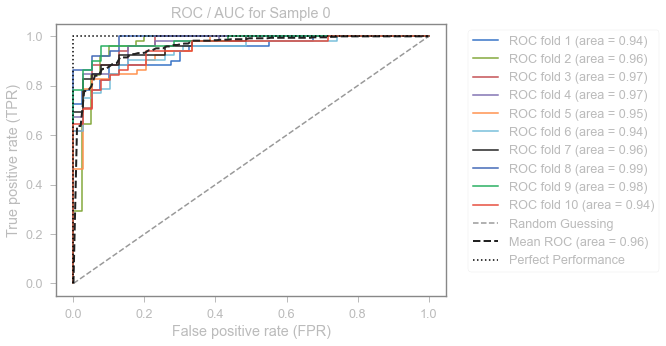

Best parameters for original reduction on Sample 1
0.8886935286935287
{'C': 1.0, 'penalty': 'l1'}
Fold:  1, Class dist.: [352 464], Train Acc.: 0.903, Test Acc.: 0.879
Fold:  2, Class dist.: [352 464], Train Acc.: 0.895, Test Acc.: 0.912
Fold:  3, Class dist.: [353 463], Train Acc.: 0.900, Test Acc.: 0.912
Fold:  4, Class dist.: [353 463], Train Acc.: 0.901, Test Acc.: 0.901
Fold:  5, Class dist.: [353 463], Train Acc.: 0.900, Test Acc.: 0.846
Fold:  6, Class dist.: [353 463], Train Acc.: 0.903, Test Acc.: 0.835
Fold:  7, Class dist.: [353 463], Train Acc.: 0.891, Test Acc.: 0.890
Fold:  8, Class dist.: [353 464], Train Acc.: 0.896, Test Acc.: 0.911
Fold:  9, Class dist.: [353 464], Train Acc.: 0.890, Test Acc.: 0.933
Fold: 10, Class dist.: [353 464], Train Acc.: 0.896, Test Acc.: 0.867

CV Train accuracy: 0.896 +/-0.000
CV Test accuracy: 0.867 +/-0.000
CV Test accuracy: 0.886 +/-0.000


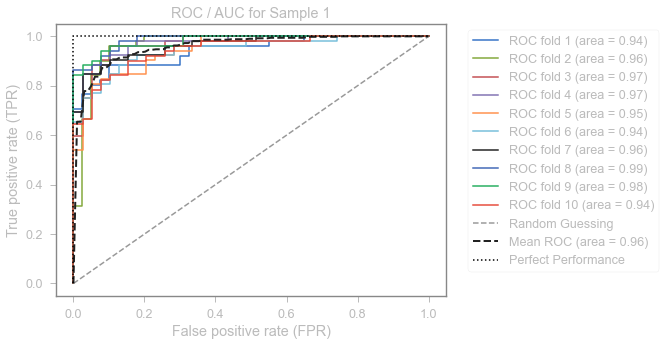

Best parameters for original reduction on Sample 2
0.8644322344322344
{'C': 1.0, 'penalty': 'l1'}
Fold:  1, Class dist.: [352 464], Train Acc.: 0.922, Test Acc.: 0.791
Fold:  2, Class dist.: [352 464], Train Acc.: 0.911, Test Acc.: 0.890
Fold:  3, Class dist.: [353 463], Train Acc.: 0.919, Test Acc.: 0.901
Fold:  4, Class dist.: [353 463], Train Acc.: 0.919, Test Acc.: 0.846
Fold:  5, Class dist.: [353 463], Train Acc.: 0.926, Test Acc.: 0.835
Fold:  6, Class dist.: [353 463], Train Acc.: 0.926, Test Acc.: 0.857
Fold:  7, Class dist.: [353 463], Train Acc.: 0.915, Test Acc.: 0.890
Fold:  8, Class dist.: [353 464], Train Acc.: 0.913, Test Acc.: 0.922
Fold:  9, Class dist.: [353 464], Train Acc.: 0.923, Test Acc.: 0.844
Fold: 10, Class dist.: [353 464], Train Acc.: 0.925, Test Acc.: 0.867

CV Train accuracy: 0.925 +/-0.000
CV Test accuracy: 0.867 +/-0.000
CV Test accuracy: 0.857 +/-0.000


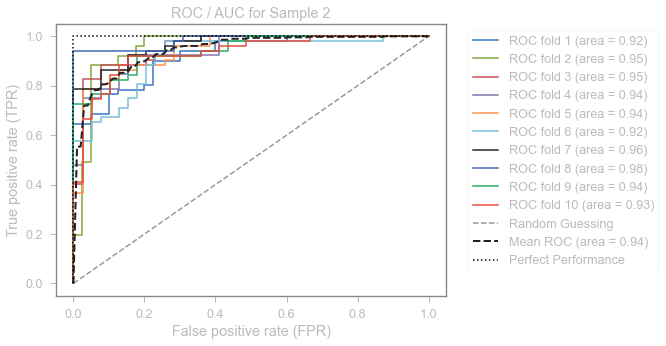

Best parameters for original reduction on Sample 3
0.8666056166056165
{'C': 2.7825594022071245, 'penalty': 'l1'}
Fold:  1, Class dist.: [352 464], Train Acc.: 0.935, Test Acc.: 0.846
Fold:  2, Class dist.: [352 464], Train Acc.: 0.935, Test Acc.: 0.890
Fold:  3, Class dist.: [353 463], Train Acc.: 0.930, Test Acc.: 0.879
Fold:  4, Class dist.: [353 463], Train Acc.: 0.935, Test Acc.: 0.857
Fold:  5, Class dist.: [353 463], Train Acc.: 0.939, Test Acc.: 0.846
Fold:  6, Class dist.: [353 463], Train Acc.: 0.936, Test Acc.: 0.879
Fold:  7, Class dist.: [353 463], Train Acc.: 0.931, Test Acc.: 0.857
Fold:  8, Class dist.: [353 464], Train Acc.: 0.927, Test Acc.: 0.922
Fold:  9, Class dist.: [353 464], Train Acc.: 0.941, Test Acc.: 0.811
Fold: 10, Class dist.: [353 464], Train Acc.: 0.945, Test Acc.: 0.878

CV Train accuracy: 0.945 +/-0.000
CV Test accuracy: 0.878 +/-0.000
CV Test accuracy: 0.800 +/-0.000


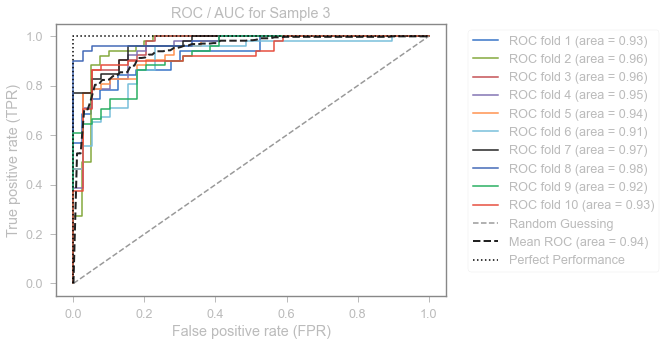

In [29]:
lr_train_accuracies = []
lr_test_accuracies = []
lr_validation_accuracies = []

for xtrs, ytr, xtes, yte, xv, yv, sample in zip(Xtrainscaleds, ytrains, Xtestscaleds, ytests, Xvalidationscaleds, 
                                                yvalidations, samples):
    log_grid_pipeline(xtrs, ytr, xtes, yte, xv, yv, sample)
    log_grid_graph(xtrs, ytr, xtes, yte, sample)
    
    lr_train_accuracies.append(log_grid_pipeline.scores_train)
    lr_test_accuracies.append(log_grid_pipeline.scores_test)
    lr_validation_accuracies.append(log_grid_pipeline.valid_accuracy)

In [30]:
lr_validation_accuracies

[0.8857142857142857, 0.8857142857142857, 0.8571428571428571, 0.8]

# SVC

Here, I follow the same process, but with a Support Vector Model classifier.

This overtrains a little bit, but I think I can control it with some lasso controls.  But honestly, I'm not terribly concerned with this much variability right now.  I'm looking for a performance baseline.

Some observations:

We're talking about marginal gains.  The POSGRU analysis adds about 3% accuracy in this logistic regression.  AMG doesn't really appear to add much value when comparing samples 2 and 3.  Is this significant?

In [31]:
def svc_grid_pipeline(xtrain, ytrain, xtest, ytest, xvalid, yvalid, sample):
    
    pipe_svc = make_pipeline(SVC(random_state = 0))

    param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
    param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},
                 {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]

    
    gs = GridSearchCV(estimator = pipe_svc, param_grid = param_grid, scoring = 'accuracy', cv = 10, refit = True, n_jobs = -1)

    gs = gs.fit(xtrain, ytrain)
    print('The best score and parameters, and overall accuracy for '+sample+' are:\n')
    print(gs.best_score_)
    print(gs.best_params_)
    
    pipe_svc = make_pipeline(SVC(kernel = gs.best_params_['svc__kernel'],C = gs.best_params_['svc__C'], random_state = 0))

    kfold = StratifiedKFold(n_splits = 10).split(xtrain, ytrain)
    
    
    for k, (train, test) in enumerate(kfold):
        pipe_svc.fit(xtrain[train], ytrain[train])
        score_train = pipe_svc.score(xtrain[train], ytrain[train])
        score_test = pipe_svc.score(xtrain[test], ytrain[test])
        print('Fold: %2d, Class dist.: %s, Train Acc.: %.3f, Test Acc.: %.3f'%(k+1, np.bincount(ytrain[train]), score_train, score_test))

    svc_grid_pipeline.train_accuracies = np.mean(score_train)
    svc_grid_pipeline.test_accuracies = np.mean(score_test)
    
    X_valid_hat = pipe_svc.predict(xvalid)
        
    valid_correct = (X_valid_hat == yvalid)
    valid_accuracy = valid_correct.sum() / valid_correct.size
    svc_grid_pipeline.valid_accuracy = valid_correct.sum() / valid_correct.size
    
    
    print('\nCV Train accuracy: %.3f +/-%.3f'%(np.mean(score_train), np.std(score_train)))
    print('CV Test accuracy: %.3f +/-%.3f'%(np.mean(score_test), np.std(score_test)))
    print('CV Validation accuracy: %.3f +/-%.3f'%(np.mean(valid_accuracy), np.std(valid_accuracy)))
    print('\n')


In [32]:
svc_train_accuracies = []
svc_test_accuracies = []
svc_validation_accuracies = []

for xtrs, ytr, xtes, yte, xv, yv, sample in zip(Xtrainscaleds, ytrains, Xtestscaleds, ytests, 
                                                Xvalidationscaleds, yvalidations, samples):
    svc_grid_pipeline(xtrs, ytr, xtes, yte, xv, yv, sample)
    
    svc_train_accuracies.append(svc_grid_pipeline.train_accuracies)
    svc_test_accuracies.append(svc_grid_pipeline.test_accuracies)
    svc_validation_accuracies.append(svc_grid_pipeline.valid_accuracy)

The best score and parameters, and overall accuracy for Sample 0 are:

0.8831746031746033
{'svc__C': 100.0, 'svc__kernel': 'linear'}
Fold:  1, Class dist.: [352 464], Train Acc.: 0.902, Test Acc.: 0.901
Fold:  2, Class dist.: [352 464], Train Acc.: 0.895, Test Acc.: 0.901
Fold:  3, Class dist.: [353 463], Train Acc.: 0.900, Test Acc.: 0.890
Fold:  4, Class dist.: [353 463], Train Acc.: 0.897, Test Acc.: 0.901
Fold:  5, Class dist.: [353 463], Train Acc.: 0.900, Test Acc.: 0.835
Fold:  6, Class dist.: [353 463], Train Acc.: 0.909, Test Acc.: 0.813
Fold:  7, Class dist.: [353 463], Train Acc.: 0.896, Test Acc.: 0.901
Fold:  8, Class dist.: [353 464], Train Acc.: 0.898, Test Acc.: 0.900
Fold:  9, Class dist.: [353 464], Train Acc.: 0.886, Test Acc.: 0.933
Fold: 10, Class dist.: [353 464], Train Acc.: 0.898, Test Acc.: 0.856

CV Train accuracy: 0.898 +/-0.000
CV Test accuracy: 0.856 +/-0.000
CV Validation accuracy: 0.886 +/-0.000


The best score and parameters, and overall accuracy for Sa

# Decision Trees

I did a Random Forest / Decision Tree classifier just because Young, et.al. used one, but I generally find them to be more useful for EDA than for good predictive power, even though they do show you feature names.

With such comparatively poor performance, I question their applicability to this dataset.

Here, I've eliminated the scaled df.  All I really need is the headers.  Maybe get this back.

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

gs_dt = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 0),
                     param_grid = [{'max_depth': [1,2,3,4,5,6,7,None]}],
                     scoring = 'accuracy',
                     cv = 5)

max_depths = []

# Xtrainscaled_dfs = [X0_train_scaled_df, X1_train_scaled_df, X2_train_scaled_df, X3_train_scaled_df]

dt_train_accuracies = []
dt_test_accuracies = []
dt_val_accuracies = []

for xtrs, ytr, xtes, yte, xv, yv, sample, xtrdfs in zip(Xtrainscaleds, ytrains, Xtestscaleds, ytests, Xvalidationscaleds,
                                                        yvalidations, samples, train_dfs):

    gs_dtf = gs_dt.fit(xtrs, ytr)
    
    print(sample+'\n')

    print(gs_dtf.best_score_)
    print(gs_dtf.best_params_)
    max_depths.append(list(gs_dtf.best_params_.values())[0])

    train_scores = cross_val_score(gs_dtf, xtrs, ytr, scoring = 'accuracy', cv = 15)
    test_scores = cross_val_score(gs_dtf, xtes, yte, scoring = 'accuracy', cv = 15)
    val_scores = cross_val_score(gs_dtf, xv, yv, scoring = 'accuracy', cv = 3)
    
    dt_train_accuracies.append(np.mean(train_scores))
    dt_test_accuracies.append(np.mean(test_scores))
    dt_val_accuracies.append(np.mean(val_scores))

    print('CV train accuracy with Decision Tree classifier: %.3f +/- %.3f'%(np.mean(train_scores), np.std(train_scores)))
    print('CV test accuracy with Decision Tree classifier: %.3f +/- %.3f'%(np.mean(test_scores), np.std(test_scores)))
    print('CV val accuracy with Decision Tree classifier: %.3f +/- %.3f'%(np.mean(val_scores), np.std(val_scores)))
    print('\n')

Sample 0

0.8125736142310729
{'max_depth': 4}
CV train accuracy with Decision Tree classifier: 0.819 +/- 0.060
CV test accuracy with Decision Tree classifier: 0.761 +/- 0.103
CV val accuracy with Decision Tree classifier: 0.886 +/- 0.103


Sample 1

0.8092769109343696
{'max_depth': 4}
CV train accuracy with Decision Tree classifier: 0.811 +/- 0.060
CV test accuracy with Decision Tree classifier: 0.752 +/- 0.108
CV val accuracy with Decision Tree classifier: 0.886 +/- 0.103


Sample 2

0.7353469734685204
{'max_depth': 3}
CV train accuracy with Decision Tree classifier: 0.713 +/- 0.042
CV test accuracy with Decision Tree classifier: 0.686 +/- 0.100
CV val accuracy with Decision Tree classifier: 0.634 +/- 0.135


Sample 3

0.7375569182199015
{'max_depth': 3}
CV train accuracy with Decision Tree classifier: 0.716 +/- 0.041
CV test accuracy with Decision Tree classifier: 0.656 +/- 0.092
CV val accuracy with Decision Tree classifier: 0.659 +/- 0.059




This just doesn't do a great job.  Fewer PI (no POSGRU differentiation) performs best, but it's not particulary great comparatively.


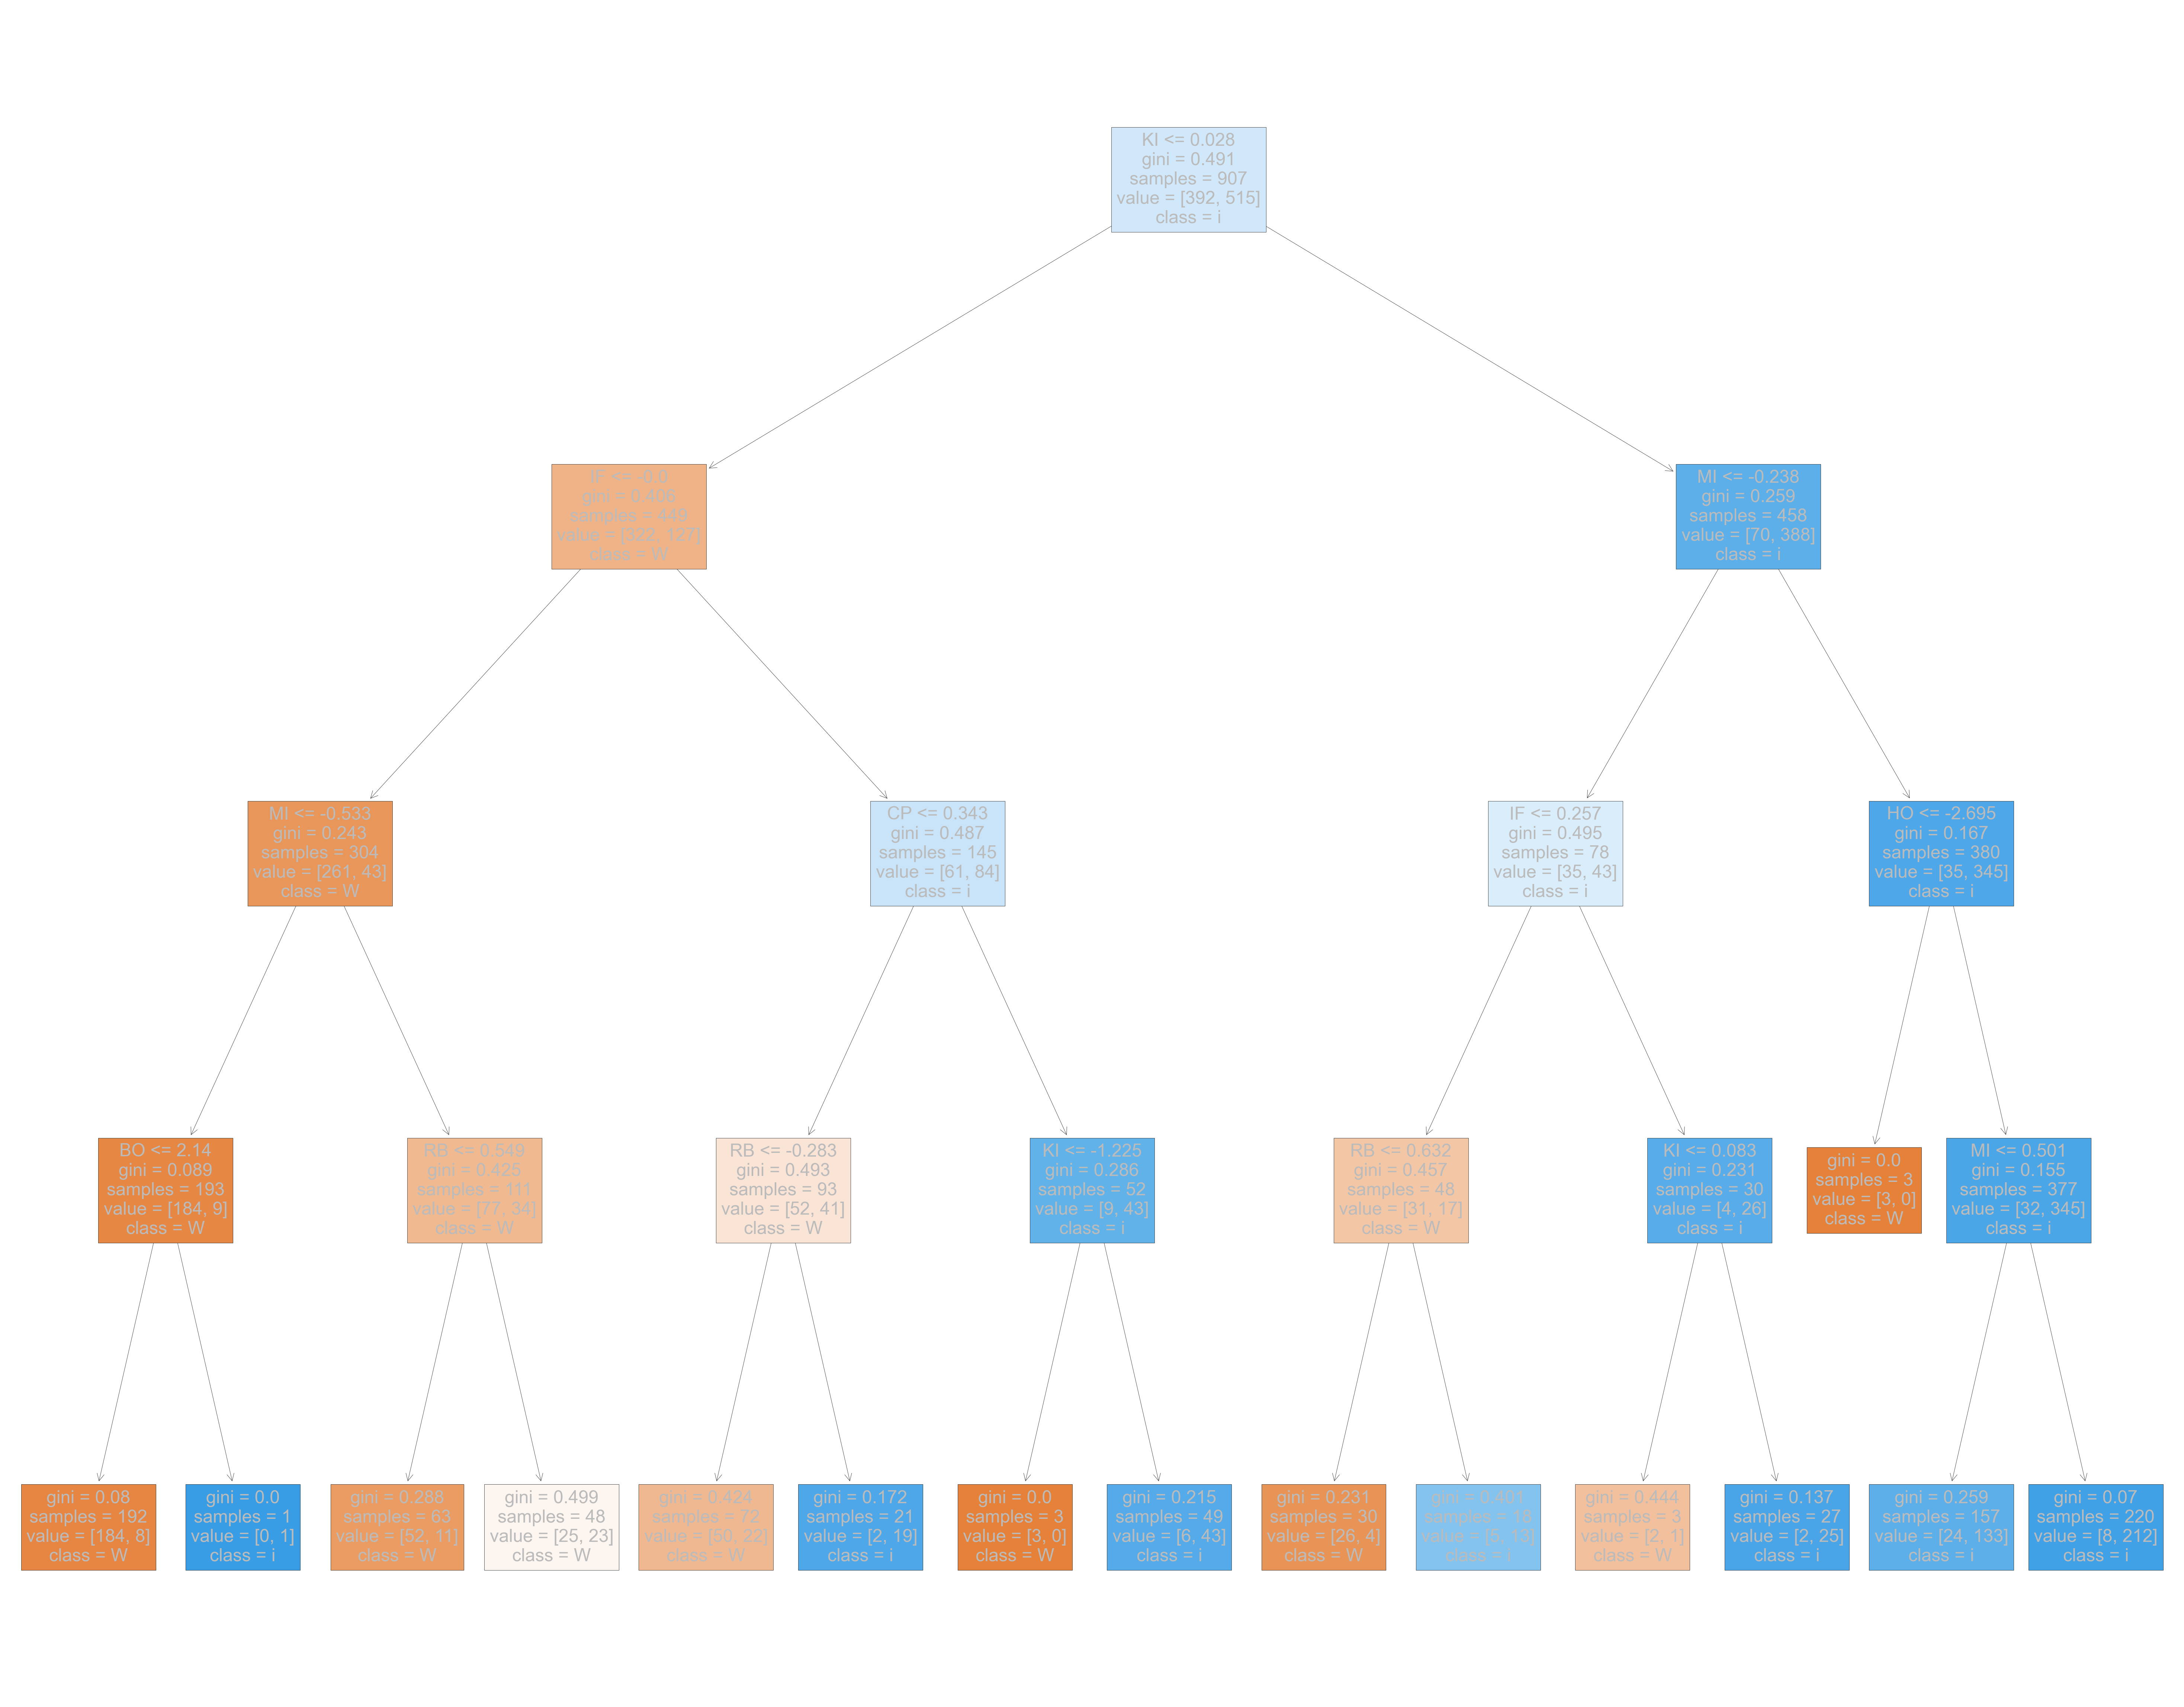

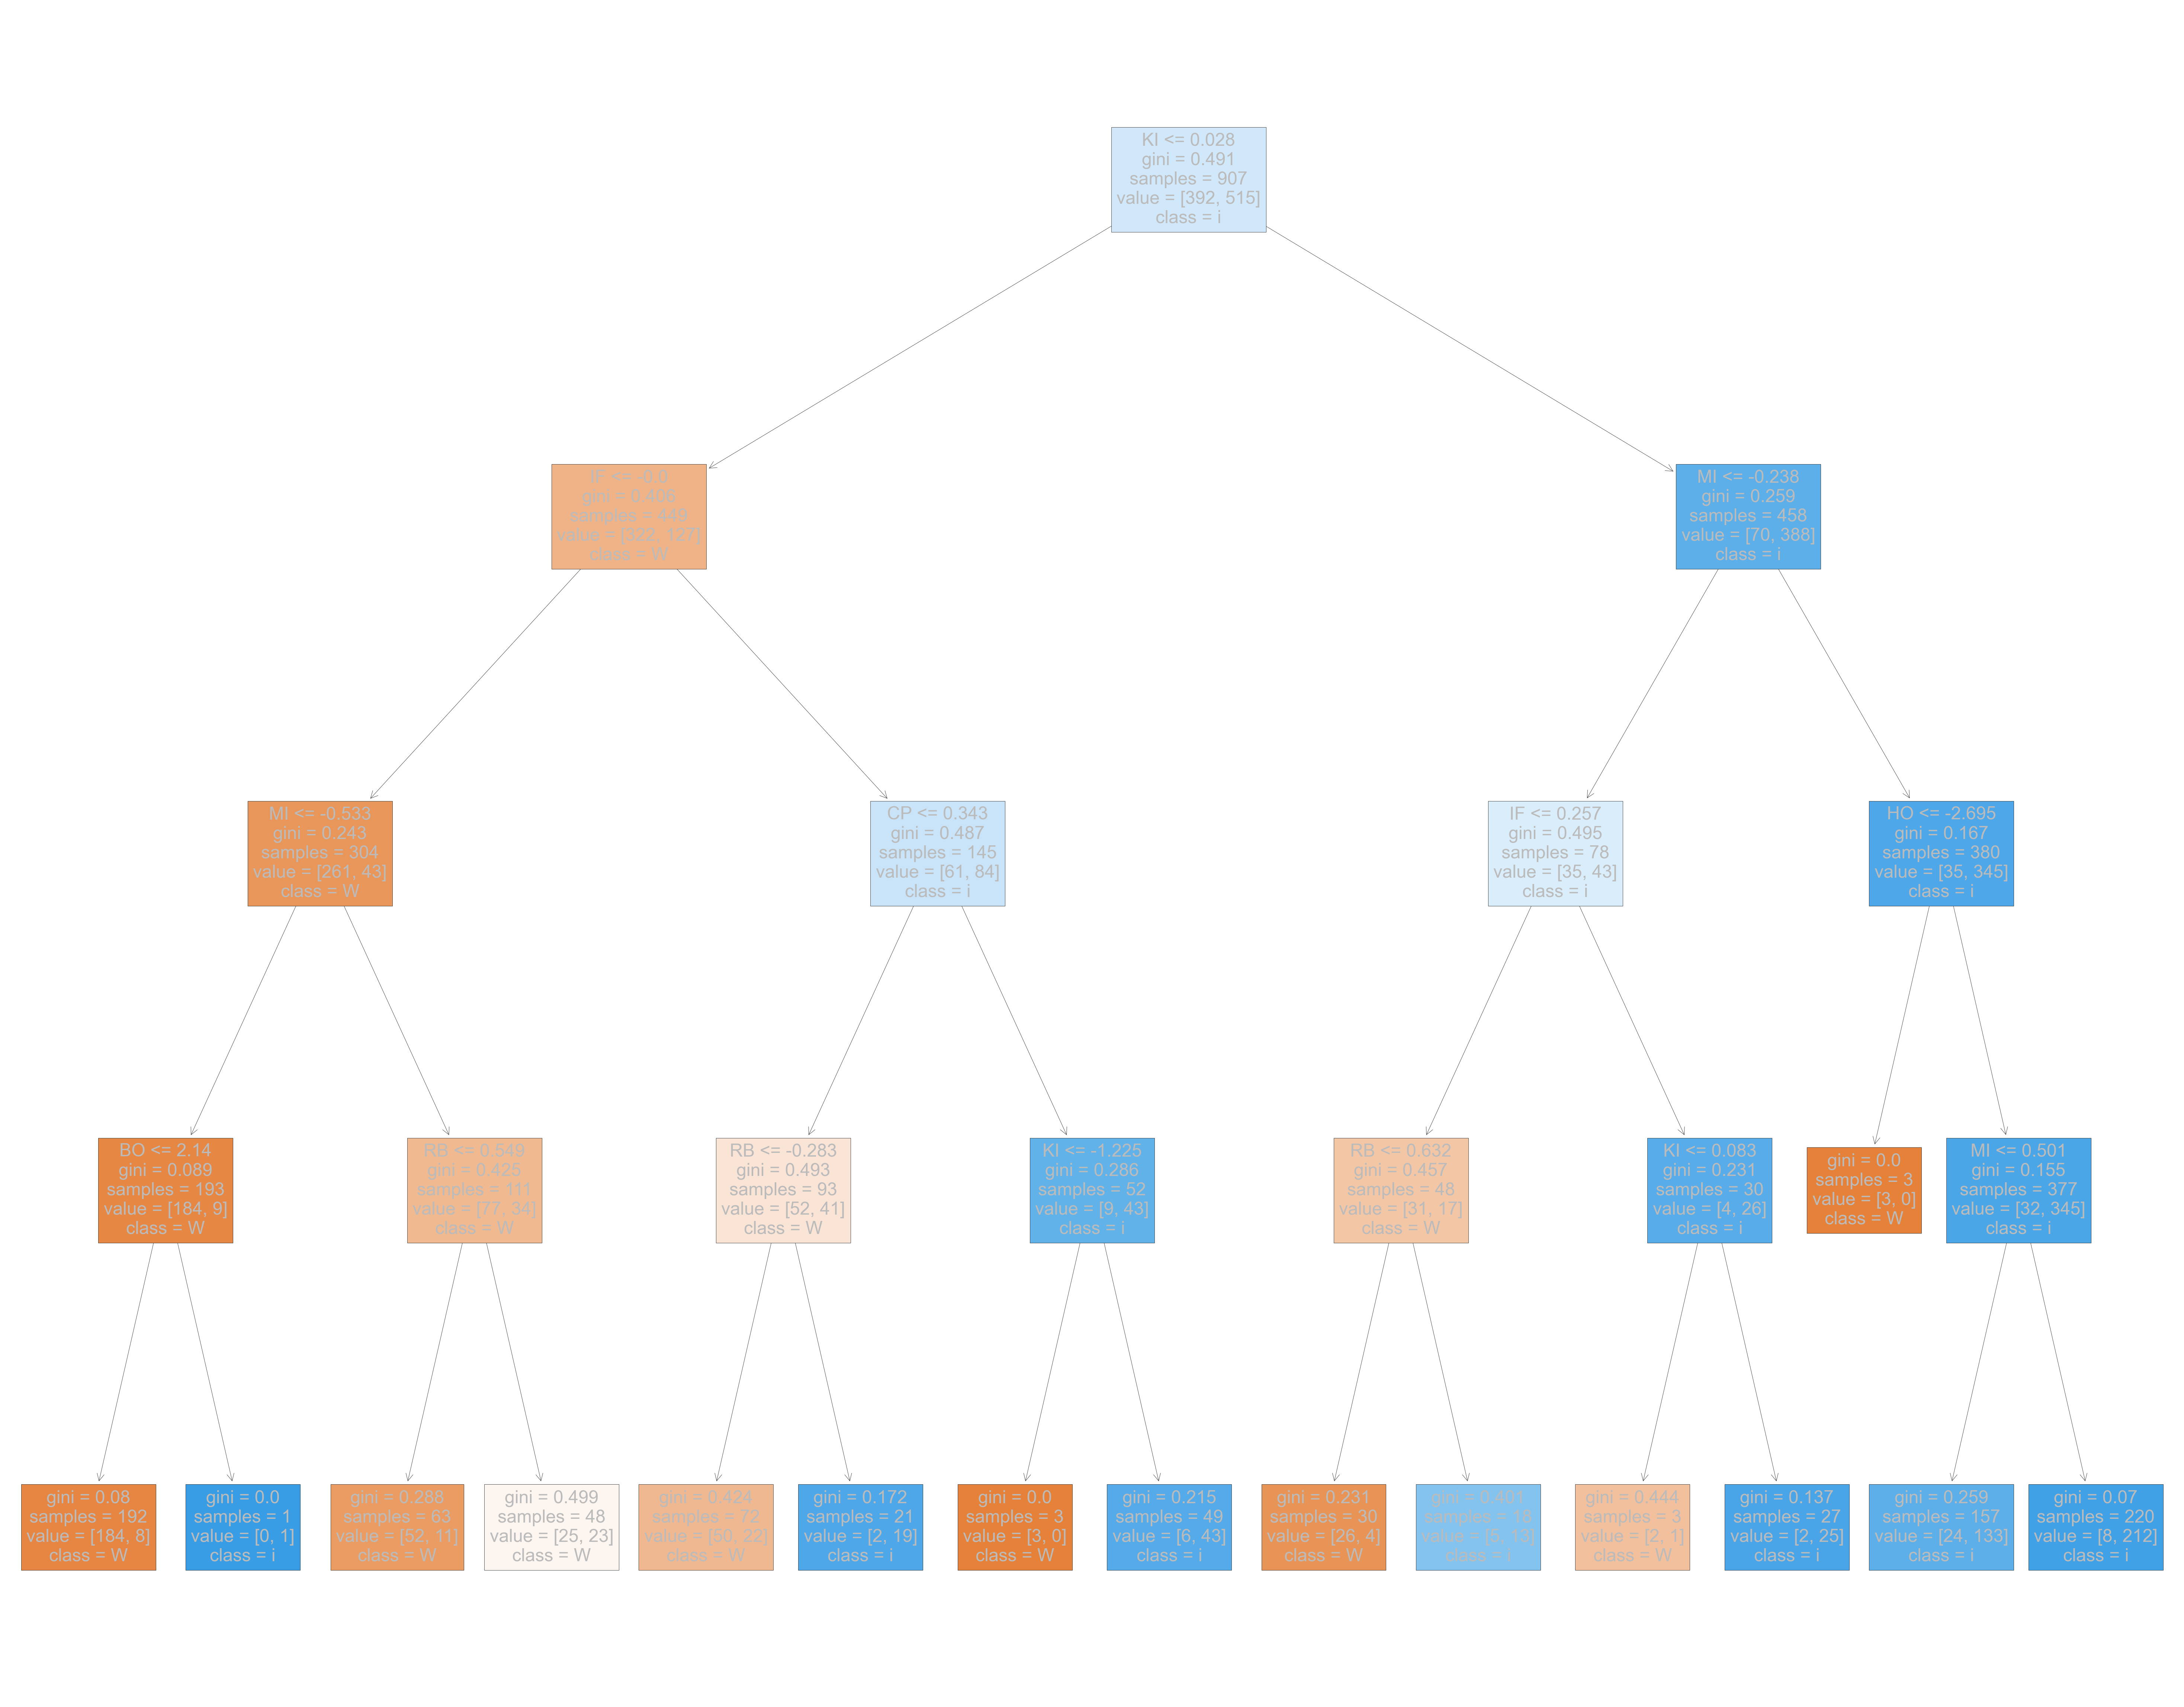

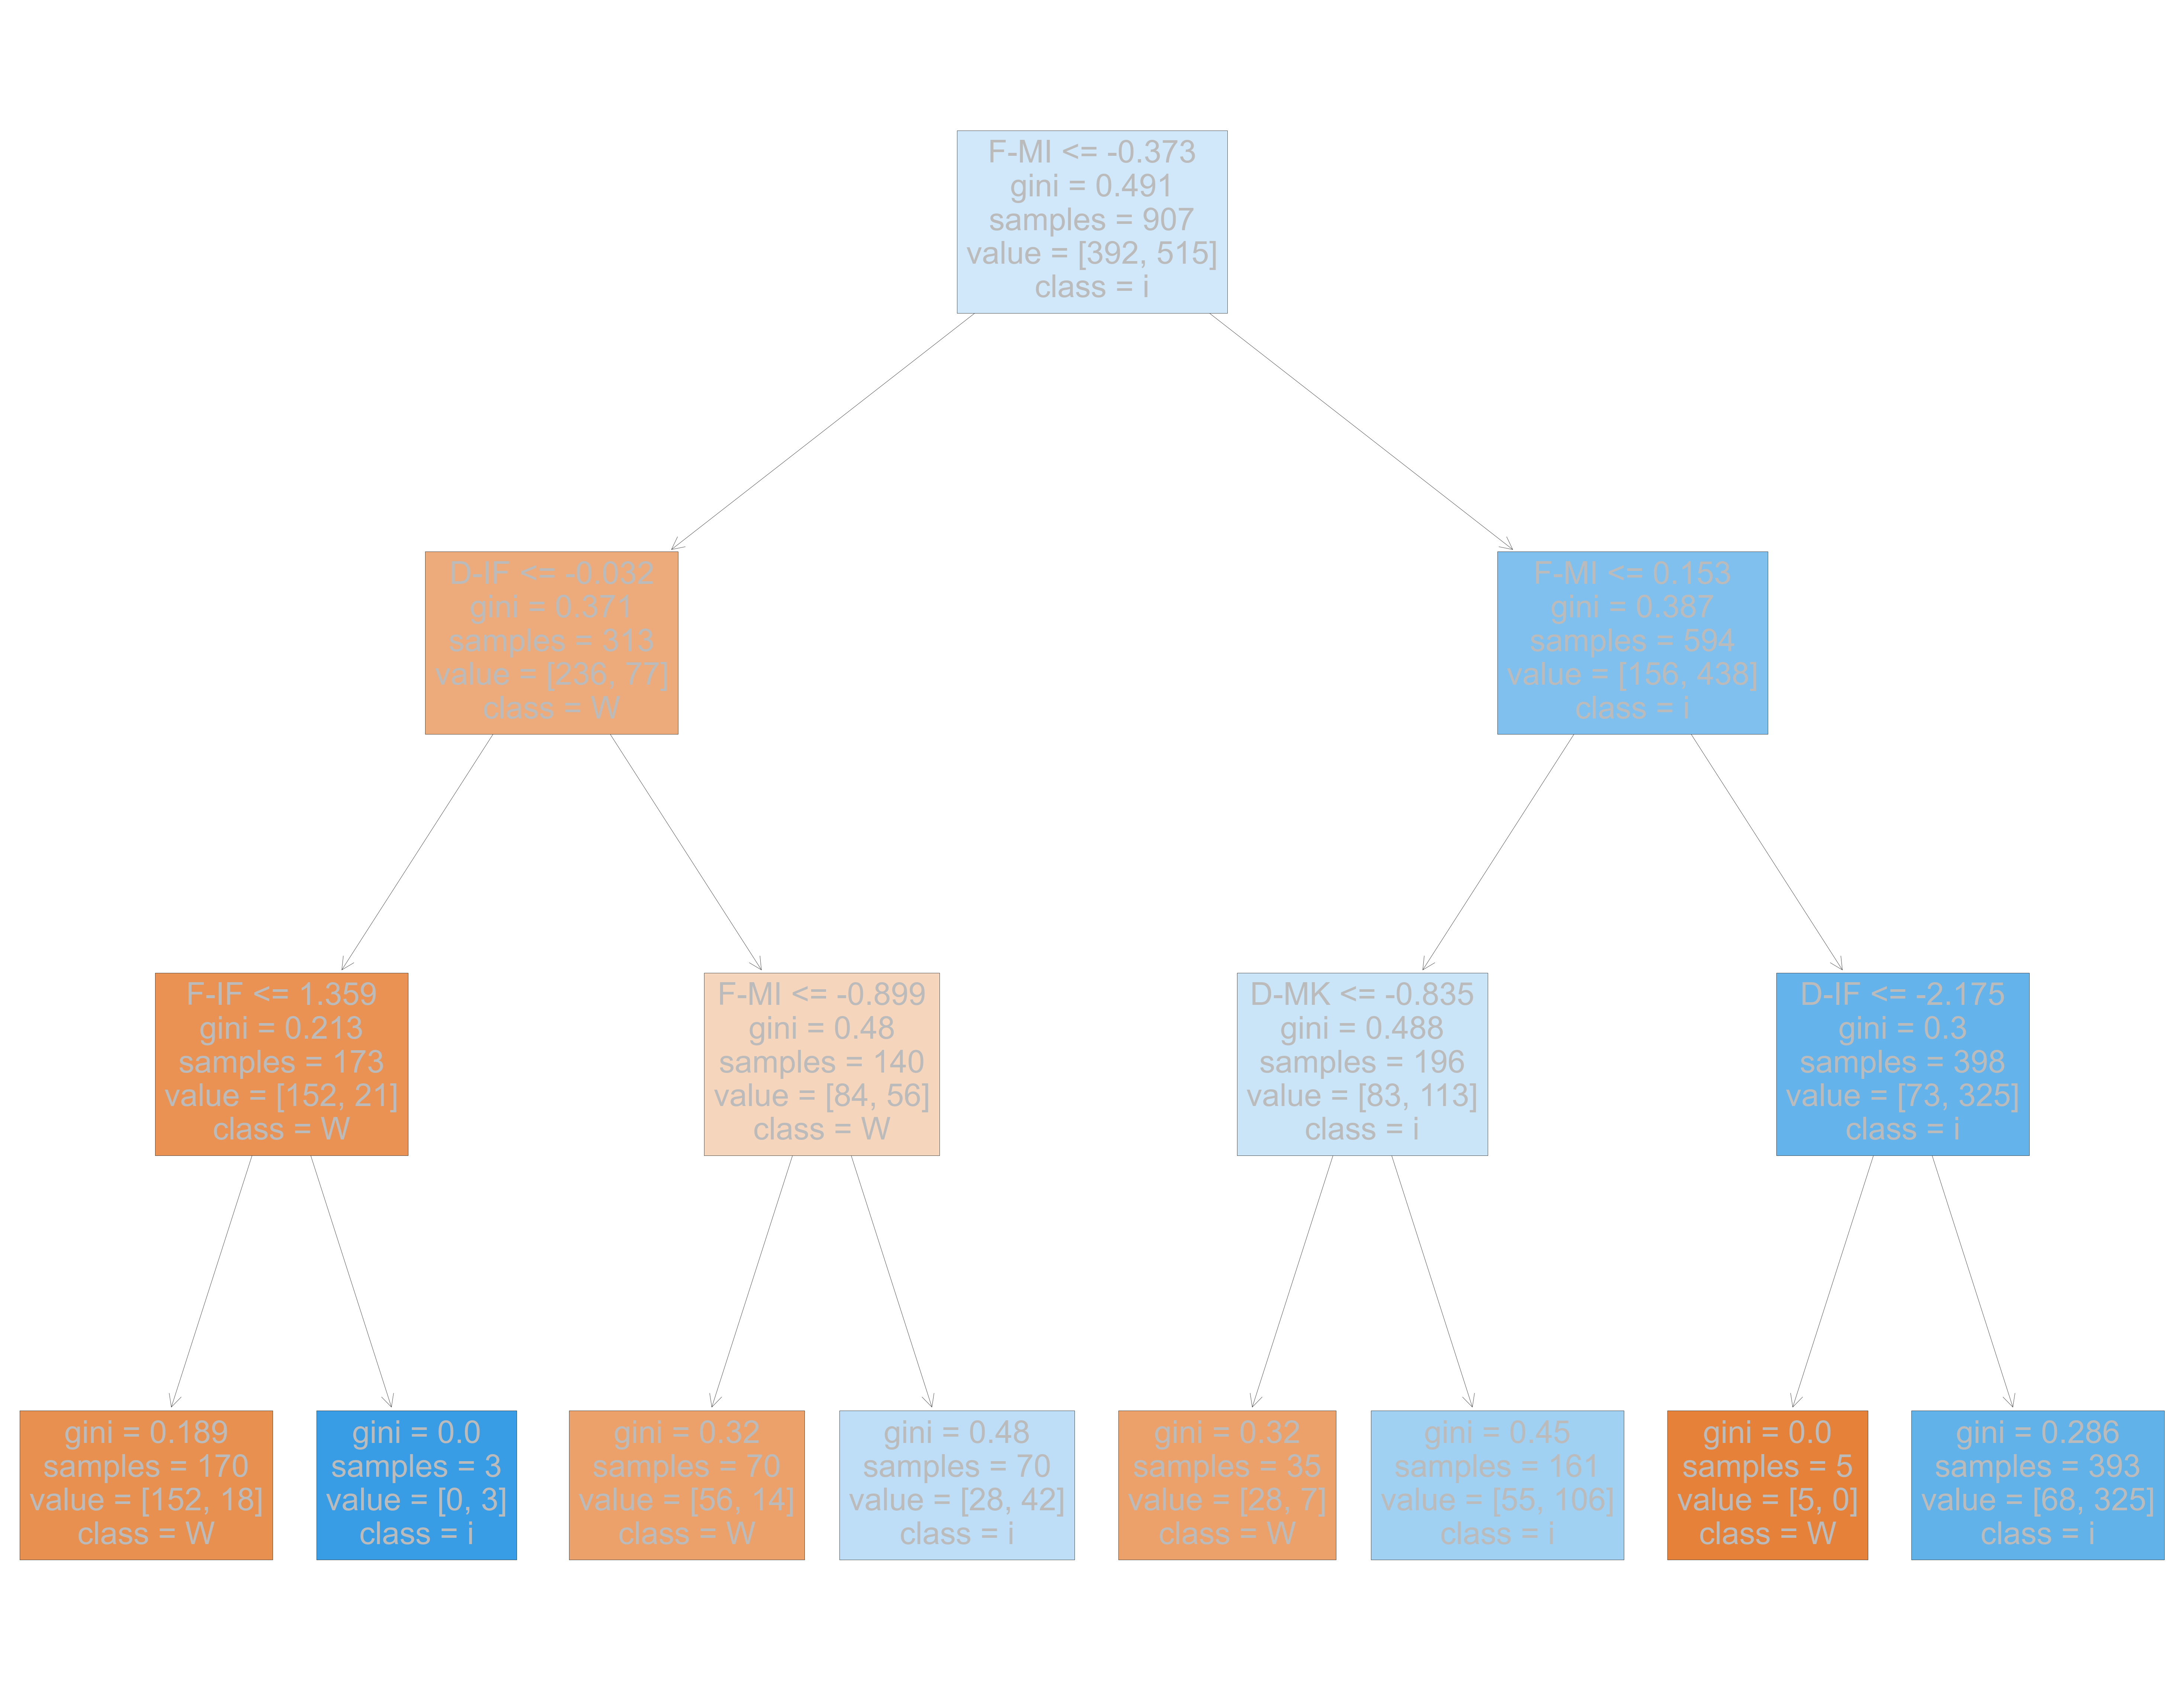

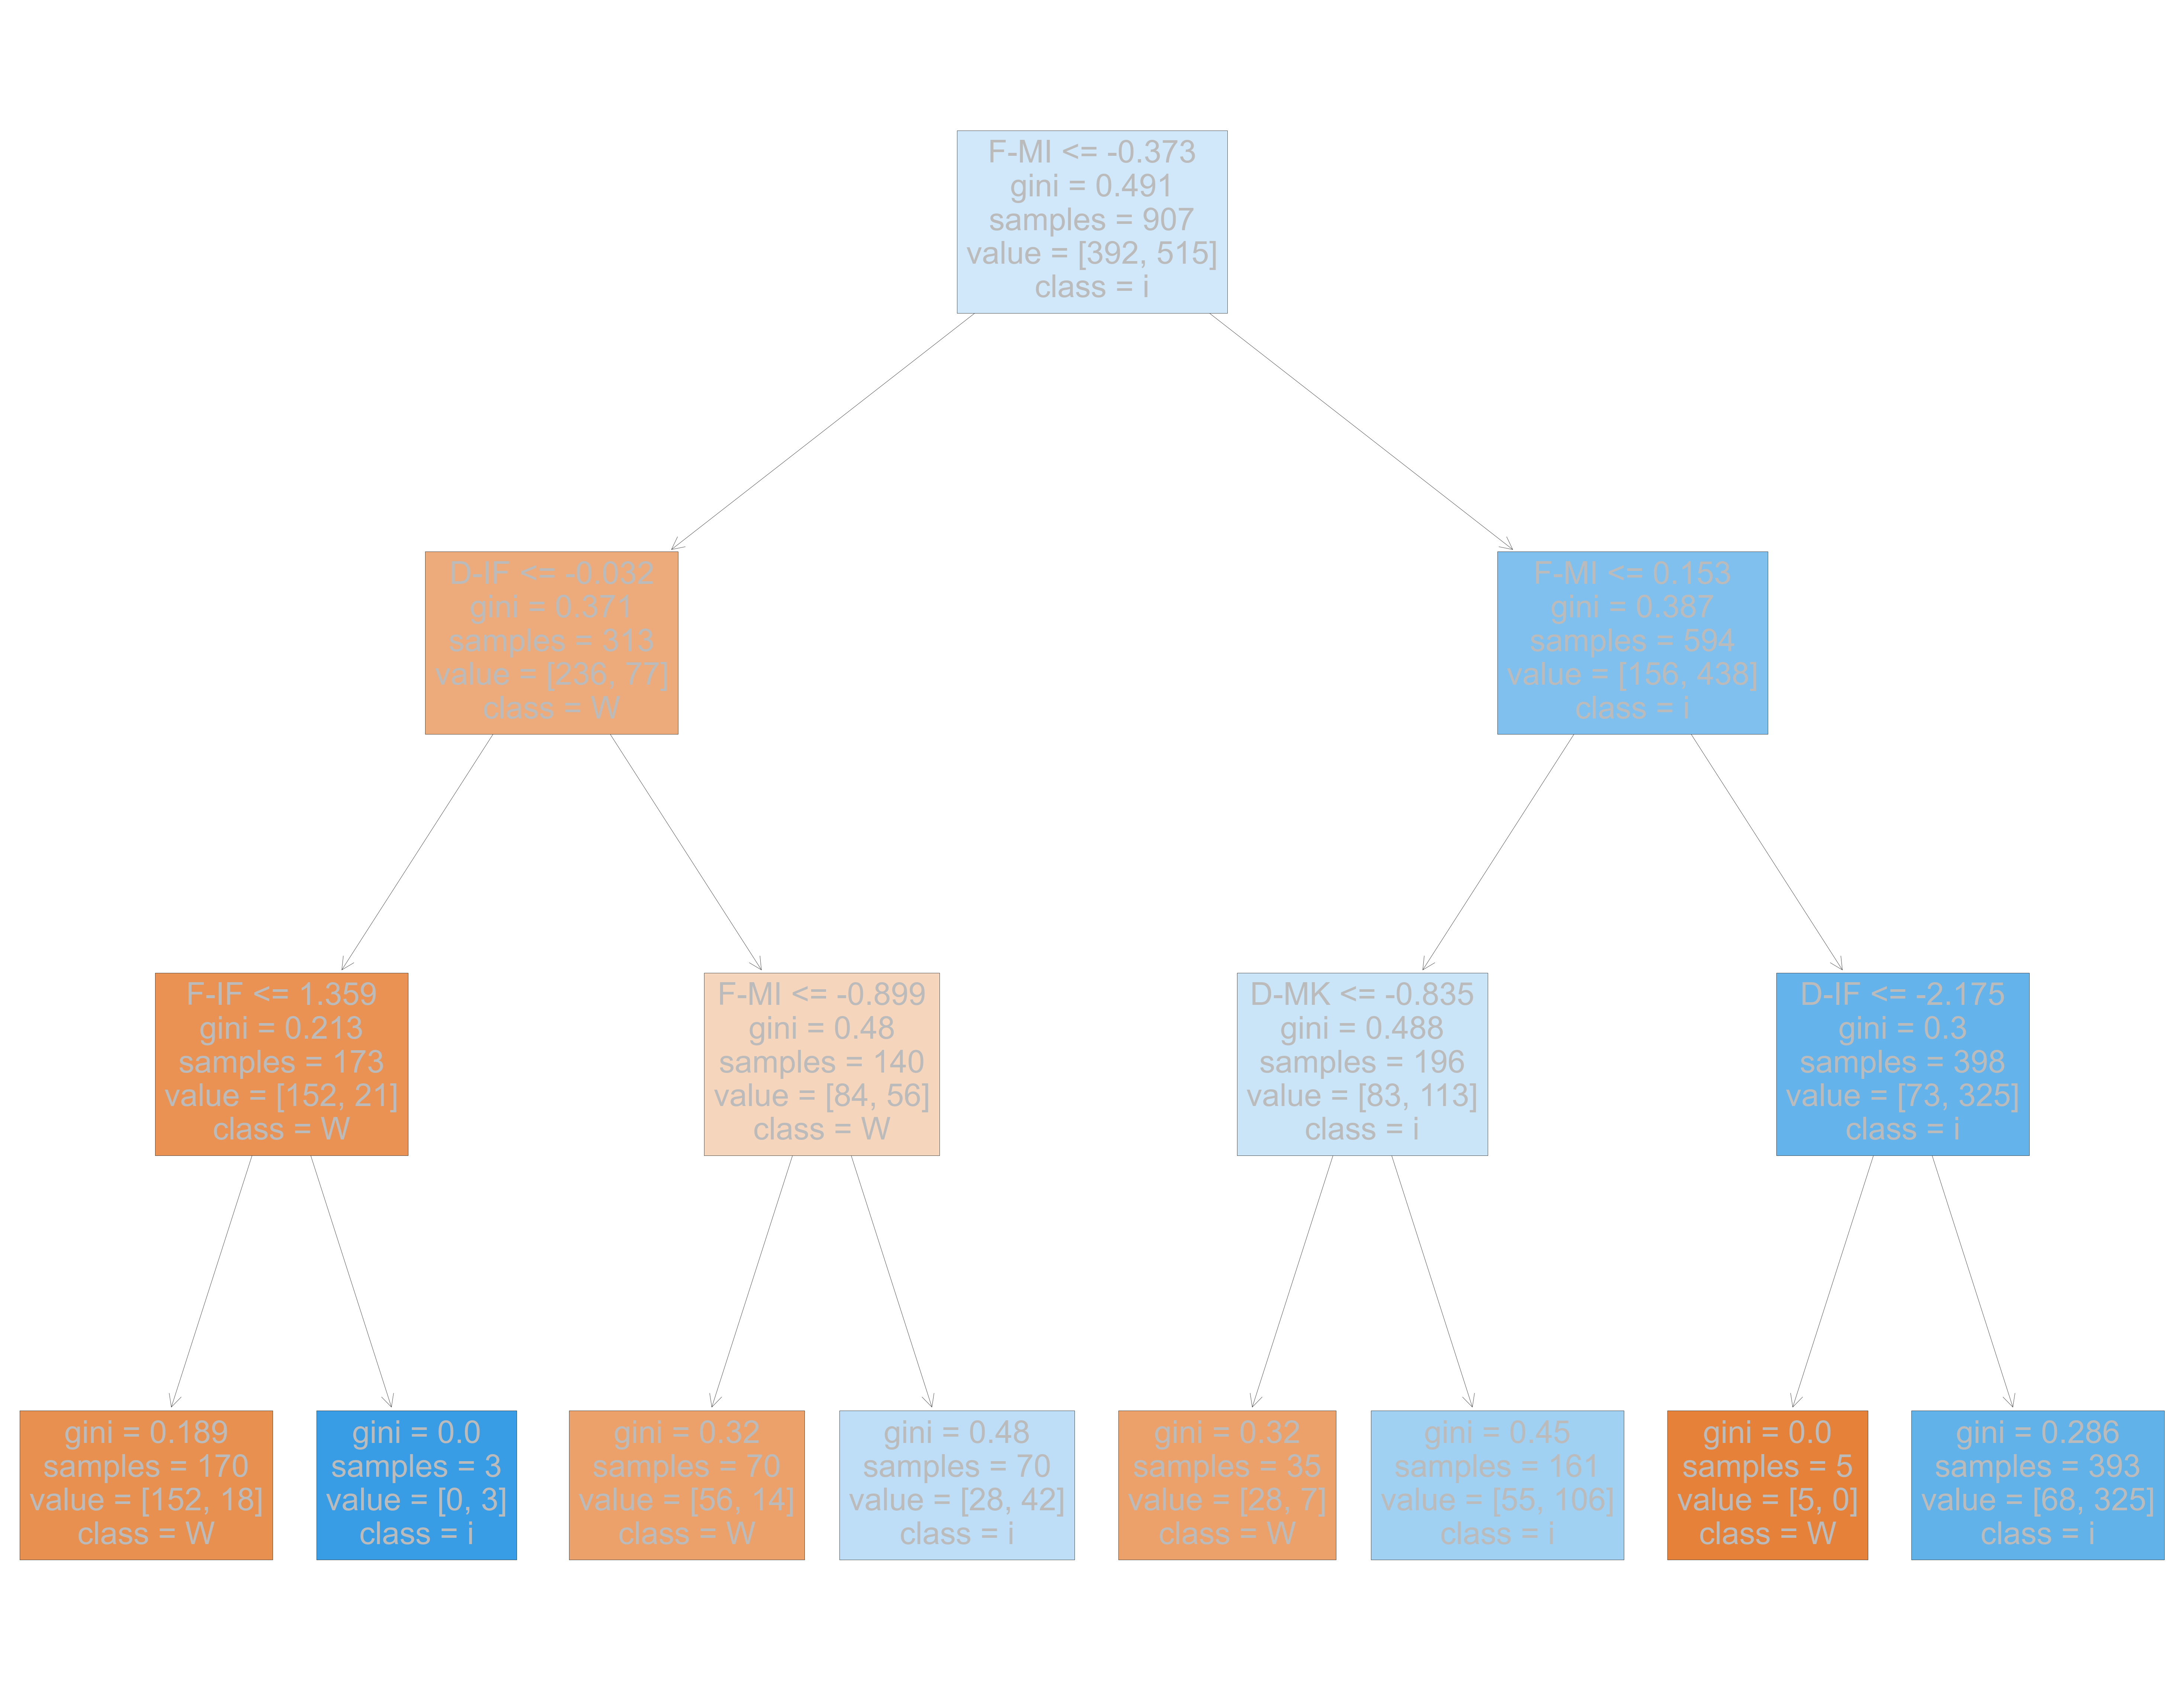

In [34]:
from sklearn import tree



for xtrs, ytr, xtes, yte, sample, xtrdfs, md in zip(Xtrainscaleds, ytrains, Xtestscaleds, 
                                                ytests, samples, train_dfs, max_depths):
    clf = DecisionTreeClassifier(max_depth = md)

    clf.fit(xtrs, ytr)
    cn = xtrdfs.columns.to_list()
    fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (25,20), dpi=300)
    plt.title('Decision Tree plot for '+sample)
    tree.plot_tree(clf, feature_names = cn, class_names = 'Winner', filled = True);

    fig.savefig(sample+'.png')

# Random Forest Classifier

Sample 0 test accuracy is:  0.8193832599118943
Sample 0 validation accuracy is:  0.8571428571428571
Sample 0 ROC_AUC value =  0.8860544217687075
   Feature  Importance
2       KI    0.160331
16      MI    0.145067
8       IF    0.080865
1       DI    0.076041
13      CP    0.067725
14      UP    0.052956
3       MK    0.050788
0      RLP    0.049979
10      CG    0.037685
7       RB    0.034202


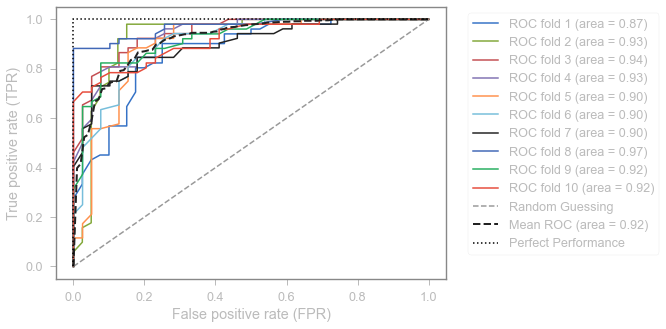

Sample 1 test accuracy is:  0.8237885462555066
Sample 1 validation accuracy is:  0.8
Sample 1 ROC_AUC value =  0.8958629963613354
   Feature  Importance
16      MI    0.147679
2       KI    0.141071
1       DI    0.082274
8       IF    0.076447
13      CP    0.062859
3       MK    0.049935
14      UP    0.049823
0      RLP    0.046508
10      CG    0.040630
19     AMG    0.036172


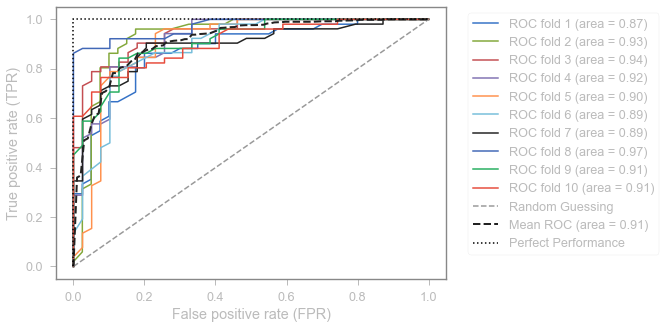

Sample 2 test accuracy is:  0.7973568281938326
Sample 2 validation accuracy is:  0.8
Sample 2 ROC_AUC value =  0.8622448979591837
    Feature  Importance
37     F-MI    0.093291
0       RLP    0.030894
92  HDAF-TM    0.030375
29     F-IF    0.030355
23     F-KI    0.028846
24     F-MK    0.023663
3      D-MK    0.023323
85  HFAD-TM    0.021714
2      D-KI    0.021599
14     D-UP    0.020745


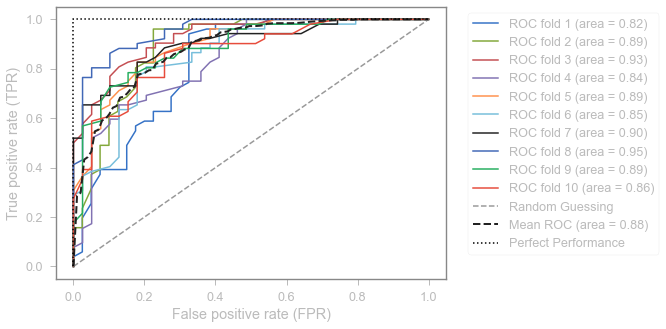

Sample 3 test accuracy is:  0.8149779735682819
Sample 3 validation accuracy is:  0.7428571428571429
Sample 3 ROC_AUC value =  0.8613352317671255
     Feature  Importance
38      F-MI    0.084052
0        RLP    0.030793
30      F-IF    0.029609
96   HDAF-TM    0.029502
25      F-MK    0.025640
3       D-MK    0.025281
52      M-IF    0.023543
89   HFAD-TM    0.022644
95  HFAD-Age    0.022205
44     F-Age    0.019920


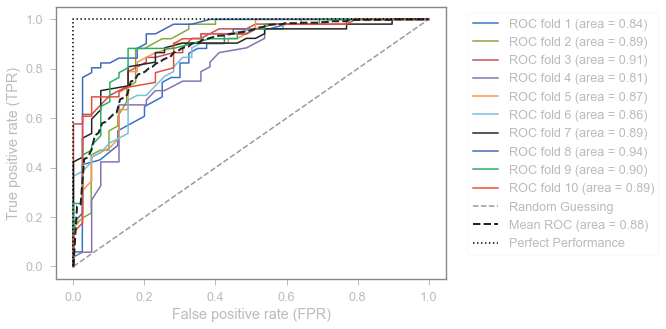

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


rf_importance_dfs = []

rf_test_accuracies = []
rf_val_accuracies = []

for xtr, xte, ytr, yte, xv, yv, samp, xts in zip(Xtrainscaleds, Xtestscaleds, ytrains, ytests, Xvalidationscaleds,
                                                 yvalidations, samples, train_dfs):

    model = RandomForestClassifier(n_estimators = 100, bootstrap = True)

    model.fit(xtr, ytr)
    predictions = model.predict(xte)
    probas = model.predict_proba(xte)[:,1]

    val_predictions = model.predict(xv)
    val_probas = model.predict_proba(xv)[:,1]
    
    
    test_accuracy = accuracy_score(yte, predictions)
    rf_test_accuracies.append(test_accuracy)
    
    val_accuracy = accuracy_score(yv, val_predictions)
    rf_val_accuracies.append(val_accuracy)

    roc_value = roc_auc_score(yte, probas)

    print(samp+' test accuracy is: ',test_accuracy)
    print(samp+' validation accuracy is: ',val_accuracy)
    print(samp+' ROC_AUC value = ',roc_value)
    key_features = pd.DataFrame({'Feature': list(xts.columns),
                                'Importance': model.feature_importances_}).sort_values('Importance', ascending = False)
    print(key_features.head(10))
    rf_importance_dfs.append(key_features)
    
    kfold = StratifiedKFold(n_splits = 10).split(xtr, ytr)
    
    cv = list(kfold)
    
    fig = plt.figure(figsize = (7, 5))
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    app_tpr = []
    
    for i, (train, test) in enumerate(cv):
        probas = model.fit(xtr[train], ytr[train]).predict_proba(xtr[test])
        fpr, tpr, thresholds = roc_curve(ytr[test], probas[:, 1], pos_label = 1)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label = 'ROC fold %d (area = %0.2f)'%(i+1, roc_auc))
    
    plt.plot([0,1], [0,1], linestyle = '--', color = (0.6, 0.6, 0.6), label = 'Random Guessing')
    
    mean_tpr/= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    
    plt.plot(mean_fpr, mean_tpr, 'k--', label = 'Mean ROC (area = %0.2f)'%mean_auc, lw = 2)
    plt.plot([0,0,1], [0,1,1], linestyle = ':', color = 'black', label = 'Perfect Performance')
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False positive rate (FPR)')
    plt.ylabel('True positive rate (TPR)')
#     plt.legend(loc = 'lower right')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.show()


# XGboost

In [36]:
# pip install xgboost

In [37]:
# from sklearn import datasets
import xgboost as xgb

In [38]:
# It works on arrays, not DataFrames

D_trains = []
D_tests = []

for xtrs, ytr, xtes, yte, sample in zip(Xtrainscaleds, ytrains, Xtestscaleds, ytests, samples):
    
    D_train = xgb.DMatrix(xtrs, label = ytr)
    D_test = xgb.DMatrix(xtes, label = yte)
    
    D_trains.append(D_train)
    D_tests.append(D_test)

In [39]:
param = {
    'eta': 0.3,
    'max_depth': 3,
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'num_class': 2}

steps = 20

In [40]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

xgboost_test_accuracies = []

for n in range(4):
    xgb_model = xgb.train(param, D_trains[n], steps)

    test_preds = xgb_model.predict(D_tests[n])
    best_test_preds = np.asarray([np.argmax(line) for line in test_preds])
    
    print('Results for : '+samples[n])
    print('Precision = {}'.format(precision_score(ytests[n], best_test_preds, average = 'macro')))
    print('Recall = {}'.format(recall_score(ytests[n], best_test_preds, average = 'macro')))
    print('Accuracy = {}'.format(accuracy_score(ytests[n], best_test_preds)))
    print('\n')
    
    xgboost_test_accuracy = accuracy_score(ytests[n], best_test_preds)
    
    xgboost_test_accuracies.append(xgboost_test_accuracy)

Results for : Sample 0
Precision = 0.8246554963983714
Recall = 0.8279939882929916
Accuracy = 0.8281938325991189


Results for : Sample 1
Precision = 0.8424485305673425
Recall = 0.8447239360860623
Accuracy = 0.8458149779735683


Results for : Sample 2
Precision = 0.7774939172749392
Recall = 0.7706454674893213
Accuracy = 0.7797356828193832


Results for : Sample 3
Precision = 0.7757633587786259
Recall = 0.7743236829615567
Accuracy = 0.7797356828193832




In [155]:
# Pre-grid search

from xgboost import XGBClassifier

XGB_test_accuracies = []
XGB_val_accuracies = []

for n in range(4):
#     xgb_model = xgb.train(param, D_trains[n], steps)

    XGB_model = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss')
    XGB_model.fit(Xtrainscaleds[n], ytrains[n])
    
    predictions = XGB_model.predict(Xtestscaleds[n])
    accuracy = accuracy_score(ytests[n], predictions)
    print('Test Accuracy: %.2f%%'%(accuracy))
    XGB_test_accuracies.append(accuracy)
    
    val_predictions = XGB_model.predict(Xvalidationscaleds[n])
    val_accuracy = accuracy_score(yvalidations[n], val_predictions)
    print('Validation Accuracy: %.2f%%'%(val_accuracy))
    XGB_val_accuracies.append(val_accuracy)
    
    features = train_dfs[n].columns
    dict_features = dict(enumerate(features))
    
    
    results = pd.DataFrame()
    results['columns'] = train_dfs[n].columns
    results['importance'] = XGB_model.feature_importances_
    results.sort_values(by = 'importance', ascending = False, inplace = True)
        
#     axsub = xgb.plot_importance(XGB_model)
    
#     # get the original names back
#     Text_yticklabels = list(axsub.get_yticklabels())
#     lst_yticklabels = [ Text_yticklabels[i].get_text().lstrip('f') for i in range(len(Text_yticklabels))]
#     lst_yticklabels = [ dict_features[int(i)] for i in lst_yticklabels]

#     axsub.set_yticklabels(lst_yticklabels)
    
    print(results.head(10))
#     plt.show()

    


Test Accuracy: 0.84%
Validation Accuracy: 0.94%
                 columns  importance
16                    MI    0.203879
2                     KI    0.192002
8                     IF    0.086998
7                     RB    0.052652
13                    CP    0.040027
10                    CG    0.037099
18                    BO    0.036350
0                    RLP    0.035219
20  Same / Neutral Venue    0.035108
19            Intrastate    0.032473
Test Accuracy: 0.85%
Validation Accuracy: 0.89%
                 columns  importance
2                     KI    0.190325
16                    MI    0.162976
8                     IF    0.080146
22                 Clash    0.066486
7                     RB    0.041723
0                    RLP    0.040785
13                    CP    0.038558
21  Same / Neutral Venue    0.037630
10                    CG    0.034010
18                    BO    0.030671
Test Accuracy: 0.78%
Validation Accuracy: 0.80%
    columns  importance
37     F-MI    0.0

# Multilayer Perceptron

I wanted to establish a baseline with the NeuralNet MLP from Rauschka, the first NeuralNet that I had ever used.

In [42]:
from urllib.request import urlretrieve

url = 'https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch12/neuralnet.py'
urlretrieve(url, 'neuralnet.py')

from neuralnet import NeuralNetMLP

Here, the hyperparameters are very clear and visible.  We can't do a grid search with this classifier, so I manipulated these hyperparameters a little bit manually, trying, unsuccessfully, to reduce loss.

I did not create a validation subset inside of the training data.  Validation  = the test data set.

In [43]:
nn = NeuralNetMLP(n_hidden = 10,
                 l2 = 0.01,
                 epochs = 200,
                 eta = 0.002,
                 minibatch_size = 50,
                 shuffle = True,
                 seed = 1)

In [44]:
def neural_network(xtrain, xtest, ytrain, ytest, sample):
    
    nn.fit(X_train = xtrain, y_train = ytrain, X_valid = xtest, y_valid = ytest)
    
    plt.plot(range(nn.epochs), nn.eval_['cost'])
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.title('Neural Network Classifier Cost for '+ sample)
    plt.show()
    
    plt.plot(range(nn.epochs), nn.eval_['train_acc'], label = 'training')
    plt.plot(range(nn.epochs), nn.eval_['valid_acc'], label = 'validation', linestyle = '--')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.title('Training Accuracy v Validation Accuracy\nwith Neural Network classifer for'+ sample)
    plt.legend(loc = 'lower right')
    neural_network.train_accuracy = nn.eval_['train_acc'][-1]
    neural_network.test_accuracy = nn.eval_['valid_acc'][-1]
    plt.show()

In [45]:
nn2 = NeuralNetMLP(n_hidden = 75,
                 l2 = 0.01,
                 epochs = 200,
                 eta = 0.002,
                 minibatch_size = 50,
                 shuffle = True,
                 seed = 1)

In [46]:
def neural_network2(xtrain, xtest, ytrain, ytest, sample):
    
    nn2.fit(X_train = xtrain, y_train = ytrain, X_valid = xtest, y_valid = ytest)
    
    plt.plot(range(nn2.epochs), nn2.eval_['cost'])
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.title('Neural Network Classifier Cost for '+ sample)
    plt.show()
    
    plt.plot(range(nn2.epochs), nn2.eval_['train_acc'], label = 'training')
    plt.plot(range(nn2.epochs), nn2.eval_['valid_acc'], label = 'validation', linestyle = '--')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.title('Training Accuracy v Validation Accuracy\nwith Neural Network classifer for'+ sample)
    plt.legend(loc = 'lower right')
    neural_network2.train_accuracy = nn2.eval_['train_acc'][-1]
    neural_network2.test_accuracy = nn2.eval_['valid_acc'][-1]
    plt.show()

200/200 | Cost: 428.28 | Train/Valid Acc.: 89.75%/89.43%  

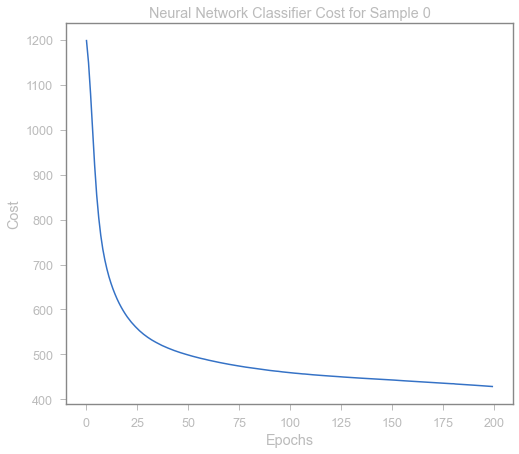

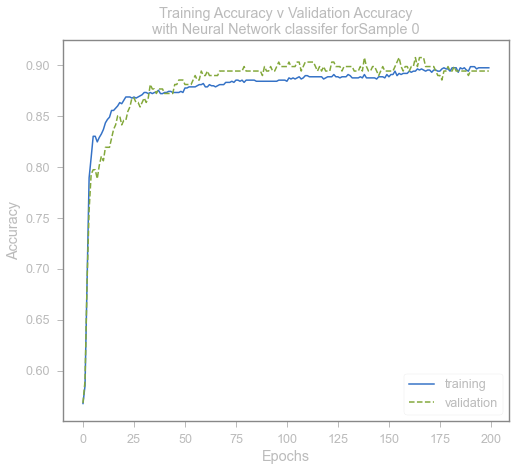

200/200 | Cost: 419.10 | Train/Valid Acc.: 90.41%/89.43%  

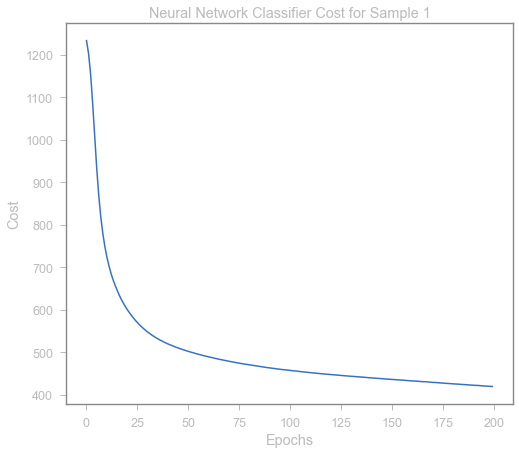

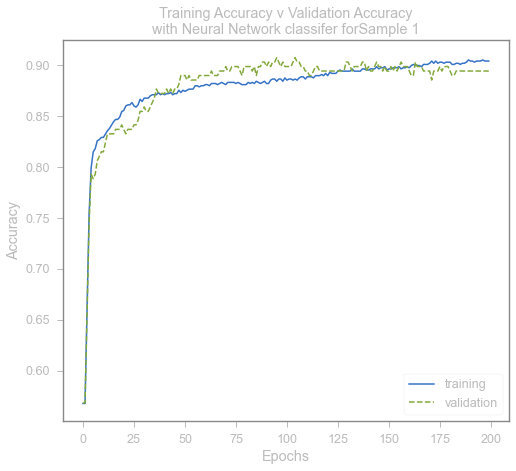

200/200 | Cost: 82.45 | Train/Valid Acc.: 99.89%/87.22%   

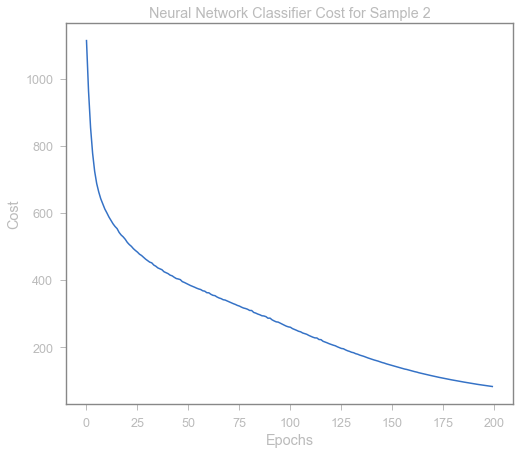

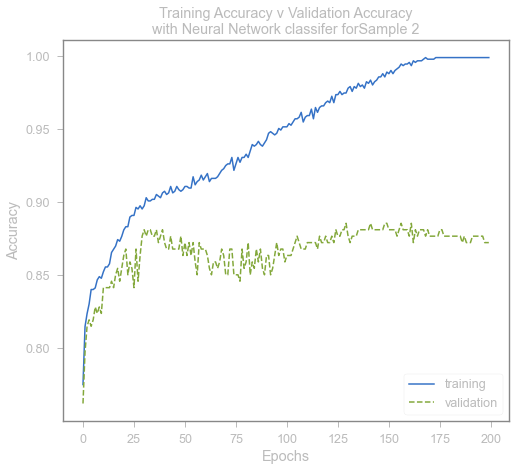

200/200 | Cost: 77.56 | Train/Valid Acc.: 99.89%/87.22%   

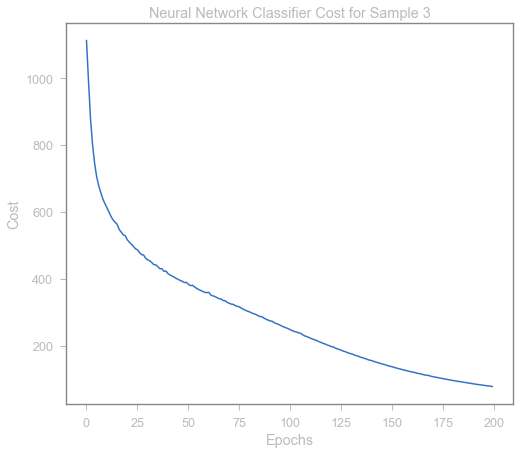

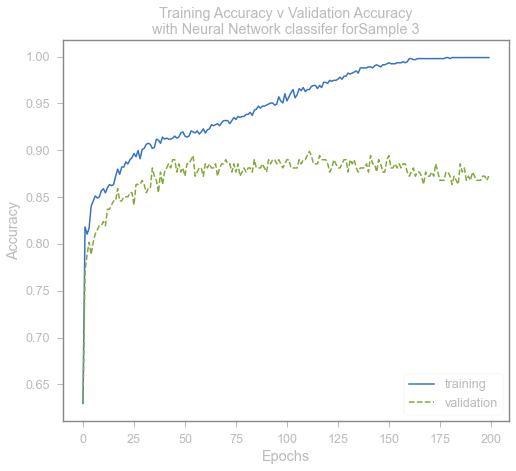

In [47]:
nn_train_accuracies = []
nn_test_accuracies = []



for n in range(4):
    
    if n < 2:
        neural_network(Xtrainscaleds[n], Xtestscaleds[n], ytrains[n], ytests[n], samples[n])
        
        nn_train_accuracies.append(neural_network.train_accuracy)
        nn_test_accuracies.append(neural_network.test_accuracy)
    else:
        neural_network2(Xtrainscaleds[n], Xtestscaleds[n], ytrains[n], ytests[n], samples[n])
        
        nn_train_accuracies.append(neural_network2.train_accuracy)
        nn_test_accuracies.append(neural_network2.test_accuracy)

    

# TensorFlow setup

Everything that I've done so far was on my initial, "regular dataset".  I cut it up and put it back together, a bunch of times, but at least I have everything normalized the way I want with the  fit.

But, let's scrap that and start fresh with TensorFlow on my smallest dataframe possible, whatever we wind up with.

Essentially, I am using a TensorFlow tutorial (https://www.tensorflow.org/tutorials/keras/regression) to start fresh with a new, un-normalized dataframe.  In these next few cells I am following that TensorFlow example to work through the TensorFlow neural network model.  Of course, I have a classification problem, not a regression problem, so the tutorial was mostly useful in the setup process.

# The ORIGINAL TensorFlow model

Tuning the TensorFlow model was arduous.  A machine that is nothing but pivot points can't do any work: something has to remain fixed to anchor the machine.  So, for me, working with TensorFlow was daunting.

Actually, the tedious dimensionality reduction process was born from my first attempt at putting the entire dataframe into TensorFlow, hoping that it would work "magic" and produce an awesome result, but it didn't.

So, I built a simple model, and then used grid search to tune the model for the best possible performance.  The main gridsearch is shown in the next section.  It took about a 1/2 day to run, so I wouldn't recommend it (I have it commented out), but this model is the result of the hyperparameter tuning that I did.

In [48]:
# Original: Dense layers: 5, 10, 5; activation: 'tanh' for all of them, 'optimizer' = Adam, lr = .002
# Ergun suggests MANY more input layers to start, and then working down

# Look for PRELU for activation?  But I can't find that.  I can find elu though


def build_model(train_scaled_df):

### I added this to deal with different feature lengths
    length = len(train_scaled_df.columns)
    layer1 = length - 4
    layer2 = layer1 / 2
    if layer2 < 40:
        layer3 = 5
    else:
        layer3 = round(layer2 / 2)
        layer4 = round(layer3 / 2)
        layer5 = 5
    
    model = tf.keras.Sequential([
            tf.keras.layers.Dense(layer1, activation = 'tanh', input_shape = [length]),
            tf.keras.layers.Dropout(rate = 0.2),
            tf.keras.layers.Dense(layer2, activation = 'tanh'),
            tf.keras.layers.Dropout(rate = 0.2),
            tf.keras.layers.Dense(layer3, activation = 'tanh'),
            tf.keras.layers.Dense(1)
        ])

    optimizer = tf.keras.optimizers.Adam(lr = .001) # originally .002
    
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model

In [49]:
def tf_complete(integer, sample):
    
    model = build_model(train_dfs[integer])
    
    model.summary()
        
    EPOCHS = 400

    history = model.fit(train_dfs[integer], ytrains[integer], batch_size = 35,
                        epochs=EPOCHS, validation_data = (test_dfs[integer], ytests[integer]), 
                        shuffle = True, verbose=0)
    print('Results for '+sample)
    
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    hist.tail()
    
    hist = history.history
    fig = plt.figure(figsize = (12,5))
    ax = fig.add_subplot(1,2,1)
    ax.plot(hist['loss'], lw = 3, label = 'Training Loss')
    ax.plot(hist['val_loss'], lw = 2, label = 'Test Loss')
    ax.set_title('Training Loss', size = 15)
    ax.set_xlabel('Epoch', size = 15)
    ax.legend(loc = 0)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
    ax = fig.add_subplot(1,2,2)
    ax.plot(hist['accuracy'], lw = 3, label = 'Training Accuracy')
    ax.plot(hist['val_accuracy'], lw = 2, label = 'Test Accuracy')
    ax.set_title('Training Accuracy', size = 15)
    ax.set_xlabel('Epoch', size = 15)
    ax.legend(loc = 0)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
    plt.show()
    

    tf_complete.results_tr = model.evaluate(train_dfs[integer], ytrains[integer], verbose = 2)
    tf_complete.results_va = model.evaluate(val_dfs[integer], yvalidations[integer], verbose = 2)
    tf_complete.results_te = model.evaluate(test_dfs[integer], ytests[integer], verbose = 2)
    print('Train loss: {:.4f} Train Acc: {:.4f}'.format(*tf_complete.results_tr))
    print('Test loss: {:.4f} Test Acc: {:.4f}'.format(*tf_complete.results_te))
    print('Validation loss: {:.4f} Validation Acc: {:.4f}'.format(*tf_complete.results_va))
    
    
    
#     results = model.evaluate(test_xs[integer], test_ys[integer], batch_size=28)
#     print("test loss, test acc:", results)
    
    pd.DataFrame(history.history).plot(figsize = (8,5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.title('Test and Validation Accuracy & Loss')
    plt.show();
    
    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 18)                414       
_________________________________________________________________
dropout (Dropout)            (None, 18)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 171       
_________________________________________________________________
dropout_1 (Dropout)          (None, 9)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 50        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 641
Trainable params: 641
Non-trainable params: 0
__________________________________________________________

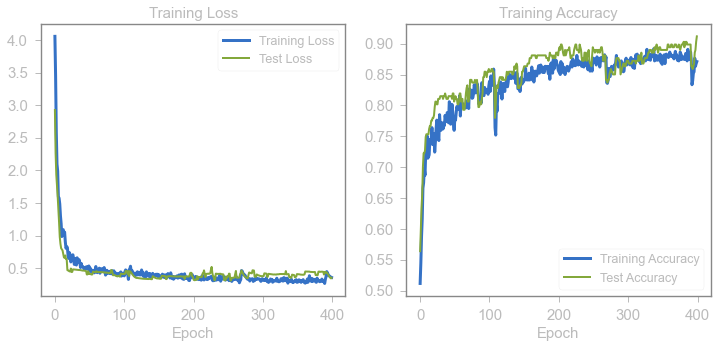

29/29 - 0s - loss: 0.3298 - accuracy: 0.8975
2/2 - 0s - loss: 0.3046 - accuracy: 0.8857
8/8 - 0s - loss: 0.3518 - accuracy: 0.9119
Train loss: 0.3298 Train Acc: 0.8975
Test loss: 0.3518 Test Acc: 0.9119
Validation loss: 0.3046 Validation Acc: 0.8857


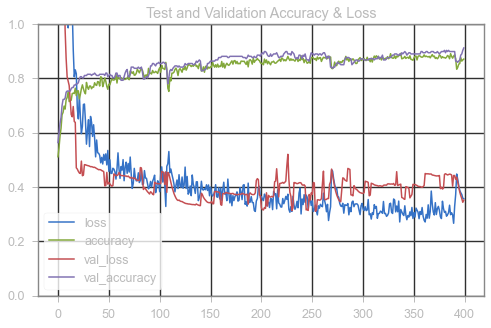

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 19)                456       
_________________________________________________________________
dropout_2 (Dropout)          (None, 19)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 9)                 180       
_________________________________________________________________
dropout_3 (Dropout)          (None, 9)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 50        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 6         
Total params: 692
Trainable params: 692
Non-trainable params: 0
________________________________________________________

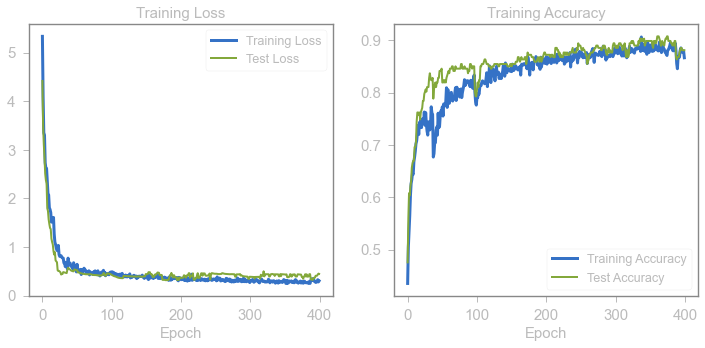

29/29 - 0s - loss: 0.2265 - accuracy: 0.8931
2/2 - 0s - loss: 0.1905 - accuracy: 0.8571
8/8 - 0s - loss: 0.4464 - accuracy: 0.8811
Train loss: 0.2265 Train Acc: 0.8931
Test loss: 0.4464 Test Acc: 0.8811
Validation loss: 0.1905 Validation Acc: 0.8571


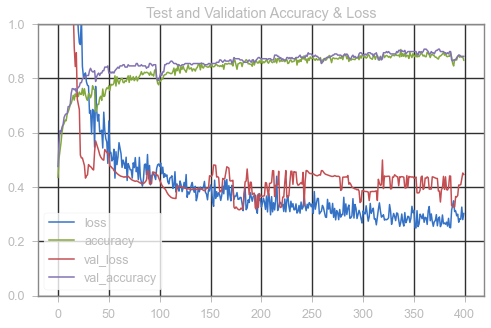

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 98)                10094     
_________________________________________________________________
dropout_4 (Dropout)          (None, 98)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 49)                4851      
_________________________________________________________________
dropout_5 (Dropout)          (None, 49)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 24)                1200      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 25        
Total params: 16,170
Trainable params: 16,170
Non-trainable params: 0
__________________________________________________

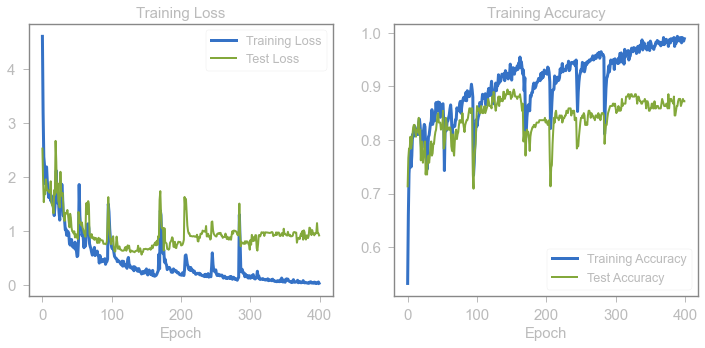

29/29 - 0s - loss: 0.0017 - accuracy: 1.0000
2/2 - 0s - loss: 0.9050 - accuracy: 0.9429
8/8 - 0s - loss: 0.9183 - accuracy: 0.8722
Train loss: 0.0017 Train Acc: 1.0000
Test loss: 0.9183 Test Acc: 0.8722
Validation loss: 0.9050 Validation Acc: 0.9429


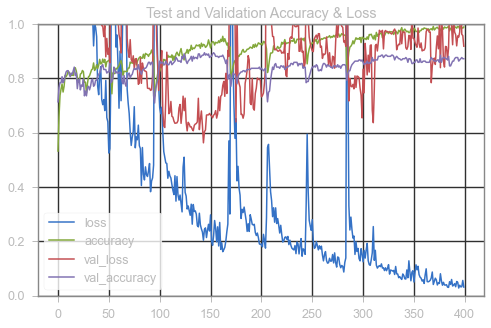

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 102)               10914     
_________________________________________________________________
dropout_6 (Dropout)          (None, 102)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 51)                5253      
_________________________________________________________________
dropout_7 (Dropout)          (None, 51)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 26)                1352      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 27        
Total params: 17,546
Trainable params: 17,546
Non-trainable params: 0
__________________________________________________

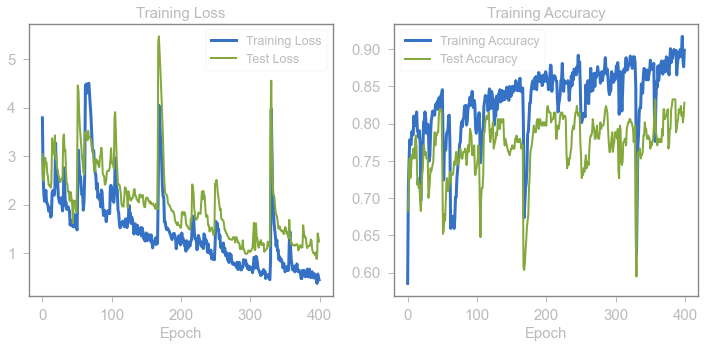

29/29 - 0s - loss: 0.3720 - accuracy: 0.9383
2/2 - 0s - loss: 1.2872 - accuracy: 0.8000
8/8 - 0s - loss: 1.2398 - accuracy: 0.8282
Train loss: 0.3720 Train Acc: 0.9383
Test loss: 1.2398 Test Acc: 0.8282
Validation loss: 1.2872 Validation Acc: 0.8000


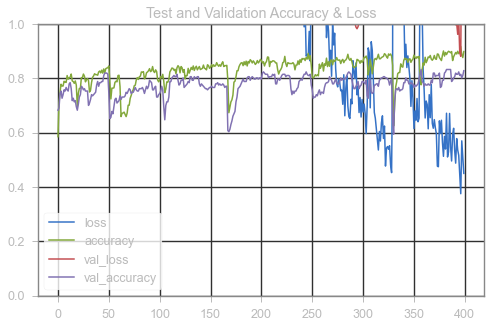

In [50]:
tf_results_train_accuracy = []
tf_results_validation_accuracy = []
tf_results_test_accuracy = []


for n, sample in zip(range(4), samples):
    tf_complete(n, sample)
    
    tf_results_train_accuracy.append(tf_complete.results_tr[1])
    tf_results_validation_accuracy.append(tf_complete.results_va[1])
    tf_results_test_accuracy.append(tf_complete.results_te[1])

# Optuna Tuning

# Notes from Optuna Keras

You can optimize Keras hyperparameters, such as the number of filters and kernel size, in three steps:

* Wrap model training with an objective function and return accuracy
* Suggest hyperparameters using a trial object
* Create a study object and execute the optimization

# These are the things that can be put into the model.

* units	Positive integer, dimensionality of the output space.

* activation	Activation function to use. If you don't specify anything, no activation is applied 
(ie. "linear" activation: a(x) = x).

* use_bias	Boolean, whether the layer uses a bias vector.

* kernel_initializer	Initializer for the kernel weights matrix.

* bias_initializer	Initializer for the bias vector.

* kernel_regularizer	Regularizer function applied to the kernel weights matrix.

* bias_regularizer	Regularizer function applied to the bias vector.

* activity_regularizer	Regularizer function applied to the output of the layer (its "activation").

* kernel_constraint	Constraint function applied to the kernel weights matrix.

* bias_constraint	Constraint function applied to the bias vector.

In [80]:
# optuna_

# 1. Define an objective function to be maximized.

def objective(trial):
    
    length = len(Xtrainscaleds[0][0])
    neurons = trial.suggest_int('neurons', 10, length)
    momentum = trial.suggest_float('momentum', 0.0, 1.0)
    learning_rate_init = trial.suggest_float('learning_rate_init', 1e-5, 1e-3, log=True)
    initializers = trial.suggest_categorical('initializers', ['uniform', 'lecun_uniform', 
                                                              'normal', 'zero', 'glorot_normal', 
                                                              'glorot_uniform', 'he_normal', 
                                                              'he_uniform'])
    activation_methods = trial.suggest_categorical('activations', ['softmax', 'softplus', 'softsign', 
                                                                    'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 
                                                                    'linear'])
    weight_constraints = trial.suggest_int('weight_constraints', 1, 5)
    EPOCHS = trial.suggest_int('epochs', 20, 100)
    BATCHSIZE = trial.suggest_int('batch', 10, 60)
    optimizers = trial.suggest_categorical('optimizer',['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 
                                                       'Adam', 'Adamax', 'Nadam'])
    n_layers = trial.suggest_int('n_layers', 1,3)
    
    model = Sequential()
    
    # 2. Suggest values of the hyperparameters using a trial object.
    # I am NOT doing a CONVOLUTIONAL layer, I am doing a DENSE layer
    
    for i in range(n_layers):
        
        num_hidden = trial.suggest_int('n_units_l{}'.format(i), 4, length, log = True)
        
        model.add(Dense(num_hidden, input_dim = length, kernel_initializer = initializers, 
                        activation = activation_methods, kernel_constraint = MaxNorm(weight_constraints)))
    model.add(Dense(1, activation='tanh'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = optimizers, metrics = ['accuracy'])
    
    model.fit(
        Xtrainscaleds[0],
        ytrains[0],
        validation_data=(Xtestscaleds[0], ytests[0]),
        shuffle=True,
        batch_size=BATCHSIZE,
        epochs=EPOCHS,
        verbose=False,
    )

    # Evaluate the model accuracy on the validation set.
    score = model.evaluate(Xtestscaleds[0], ytests[0], verbose=0)
    val_score = model.evaluate(Xvalidationscaleds[0], yvalidations[0], verbose = 0)
    
    objective.scores = (score[1], val_score[1])
    
    
    return score[1]




In [81]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

optuna_score = []
print("  Value: {}".format(trial.value))
optuna_score.append(trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    

    

[I 2021-05-02 13:55:39,302] A new study created in memory with name: no-name-5c37d076-1b5f-4c50-8066-ce80aec4c12a
[I 2021-05-02 13:55:44,440] Trial 0 finished with value: 0.43171805143356323 and parameters: {'neurons': 21, 'momentum': 0.6293763075360199, 'learning_rate_init': 0.00028857773693241075, 'initializers': 'lecun_uniform', 'activations': 'hard_sigmoid', 'weight_constraints': 4, 'epochs': 42, 'batch': 39, 'optimizer': 'RMSprop', 'n_layers': 2, 'n_units_l0': 5, 'n_units_l1': 10}. Best is trial 0 with value: 0.43171805143356323.
[I 2021-05-02 13:55:49,148] Trial 1 finished with value: 0.8193832635879517 and parameters: {'neurons': 20, 'momentum': 0.7614443257568357, 'learning_rate_init': 3.94209578632401e-05, 'initializers': 'lecun_uniform', 'activations': 'relu', 'weight_constraints': 3, 'epochs': 37, 'batch': 58, 'optimizer': 'Nadam', 'n_layers': 3, 'n_units_l0': 7, 'n_units_l1': 20, 'n_units_l2': 13}. Best is trial 1 with value: 0.8193832635879517.
[I 2021-05-02 13:55:57,322] 

[I 2021-05-02 13:59:03,493] Trial 19 finished with value: 0.8370044231414795 and parameters: {'neurons': 11, 'momentum': 0.49410845094906003, 'learning_rate_init': 1.74621983227507e-05, 'initializers': 'glorot_normal', 'activations': 'softmax', 'weight_constraints': 2, 'epochs': 82, 'batch': 58, 'optimizer': 'RMSprop', 'n_layers': 3, 'n_units_l0': 12, 'n_units_l1': 4, 'n_units_l2': 13}. Best is trial 9 with value: 0.8898678421974182.
[I 2021-05-02 13:59:17,479] Trial 20 finished with value: 0.8325991034507751 and parameters: {'neurons': 13, 'momentum': 0.8167937392900925, 'learning_rate_init': 3.072106773926099e-05, 'initializers': 'he_uniform', 'activations': 'tanh', 'weight_constraints': 4, 'epochs': 100, 'batch': 18, 'optimizer': 'Adam', 'n_layers': 2, 'n_units_l0': 5, 'n_units_l1': 6}. Best is trial 9 with value: 0.8898678421974182.
[I 2021-05-02 13:59:29,601] Trial 21 finished with value: 0.8810572624206543 and parameters: {'neurons': 12, 'momentum': 0.30873077047368436, 'learning

[I 2021-05-02 14:02:26,154] Trial 39 finished with value: 0.8281938433647156 and parameters: {'neurons': 10, 'momentum': 0.623613218191577, 'learning_rate_init': 1.3299781127838882e-05, 'initializers': 'he_normal', 'activations': 'relu', 'weight_constraints': 4, 'epochs': 96, 'batch': 31, 'optimizer': 'Nadam', 'n_layers': 2, 'n_units_l0': 18, 'n_units_l1': 4}. Best is trial 9 with value: 0.8898678421974182.
[I 2021-05-02 14:02:32,218] Trial 40 finished with value: 0.784140944480896 and parameters: {'neurons': 15, 'momentum': 0.266125820514061, 'learning_rate_init': 1.0249282711475698e-05, 'initializers': 'normal', 'activations': 'sigmoid', 'weight_constraints': 5, 'epochs': 51, 'batch': 53, 'optimizer': 'Adam', 'n_layers': 1, 'n_units_l0': 9}. Best is trial 9 with value: 0.8898678421974182.
[I 2021-05-02 14:02:45,971] Trial 41 finished with value: 0.8854625821113586 and parameters: {'neurons': 12, 'momentum': 0.19523485325419232, 'learning_rate_init': 1.7927706244838977e-05, 'initializ

Number of finished trials: 55
Best trial:
  Value: 0.8898678421974182
  Params: 
    neurons: 14
    momentum: 0.9507814928796865
    learning_rate_init: 2.2771905147716246e-05
    initializers: uniform
    activations: linear
    weight_constraints: 5
    epochs: 86
    batch: 35
    optimizer: Nadam
    n_layers: 3
    n_units_l0: 10
    n_units_l1: 5
    n_units_l2: 12


In [82]:
optuna_val_scores = []

optuna_val_scores.append(objective.scores[1])

In [ ]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(study)

In [84]:
from optuna.visualization import plot_param_importances

plot_param_importances(study)

In [88]:
def objective(trial):
    
    length = len(Xtrainscaleds[1][0])
    neurons = trial.suggest_int('neurons', 10, length)
    momentum = trial.suggest_float('momentum', 0.0, 1.0)
    learning_rate_init = trial.suggest_float('learning_rate_init', 1e-5, 1e-3, log=True)
    initializers = trial.suggest_categorical('initializers', ['uniform', 'lecun_uniform', 
                                                              'normal', 'zero', 'glorot_normal', 
                                                              'glorot_uniform', 'he_normal', 
                                                              'he_uniform'])
    activation_methods = trial.suggest_categorical('activations', ['softmax', 'softplus', 'softsign', 
                                                                    'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 
                                                                    'linear'])
    weight_constraints = trial.suggest_int('weight_constraints', 1, 5)
    EPOCHS = trial.suggest_int('epochs', 20, 100)
    BATCHSIZE = trial.suggest_int('batch', 10, 60)
    optimizers = trial.suggest_categorical('optimizer',['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 
                                                       'Adam', 'Adamax', 'Nadam'])
    n_layers = trial.suggest_int('n_layers', 1,3)
    
    model = Sequential()
    
    # 2. Suggest values of the hyperparameters using a trial object.
    # I am NOT doing a CONVOLUTIONAL layer, I am doing a DENSE layer
    
    for i in range(n_layers):
        
        num_hidden = trial.suggest_int('n_units_l{}'.format(i), 4, length, log = True)
        
        model.add(Dense(num_hidden, input_dim = length, kernel_initializer = initializers, 
                        activation = activation_methods, kernel_constraint = MaxNorm(weight_constraints)))
    model.add(Dense(1, activation='tanh'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = optimizers, metrics = ['accuracy'])
    
    model.fit(
        Xtrainscaleds[1],
        ytrains[1],
        validation_data=(Xtestscaleds[1], ytests[1]),
        shuffle=True,
        batch_size=BATCHSIZE,
        epochs=EPOCHS,
        verbose=False,
    )

    # Evaluate the model accuracy on the validation set.
    score = model.evaluate(Xtestscaleds[1], ytests[1], verbose=0)
    val_score = model.evaluate(Xvalidationscaleds[1], yvalidations[1], verbose = 0)
    
    objective.scores = (score[1], val_score[1])
    
    return score[1]




In [89]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
optuna_score.append(trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-05-02 14:43:45,040] A new study created in memory with name: no-name-2bb59ce4-fd36-41f3-95b1-d88dc66a2d84
[I 2021-05-02 14:43:57,243] Trial 0 finished with value: 0.8986784219741821 and parameters: {'neurons': 20, 'momentum': 0.7220494069016227, 'learning_rate_init': 0.0005142230402759781, 'initializers': 'he_normal', 'activations': 'linear', 'weight_constraints': 5, 'epochs': 65, 'batch': 10, 'optimizer': 'RMSprop', 'n_layers': 1, 'n_units_l0': 8}. Best is trial 0 with value: 0.8986784219741821.
[I 2021-05-02 14:44:11,198] Trial 1 finished with value: 0.5682819485664368 and parameters: {'neurons': 16, 'momentum': 0.4400399044602046, 'learning_rate_init': 0.00048382458682094903, 'initializers': 'he_uniform', 'activations': 'tanh', 'weight_constraints': 5, 'epochs': 94, 'batch': 16, 'optimizer': 'SGD', 'n_layers': 3, 'n_units_l0': 4, 'n_units_l1': 4, 'n_units_l2': 15}. Best is trial 0 with value: 0.8986784219741821.
[I 2021-05-02 14:44:19,348] Trial 2 finished with value: 0.4317

[I 2021-05-02 14:47:37,113] Trial 20 finished with value: 0.8766520023345947 and parameters: {'neurons': 23, 'momentum': 0.0044739260599853115, 'learning_rate_init': 0.0003366684825891634, 'initializers': 'uniform', 'activations': 'relu', 'weight_constraints': 4, 'epochs': 31, 'batch': 18, 'optimizer': 'Adam', 'n_layers': 2, 'n_units_l0': 8, 'n_units_l1': 6}. Best is trial 17 with value: 0.9030836820602417.
[I 2021-05-02 14:47:50,082] Trial 21 finished with value: 0.8986784219741821 and parameters: {'neurons': 18, 'momentum': 0.5592792886253538, 'learning_rate_init': 2.106846356890635e-05, 'initializers': 'glorot_uniform', 'activations': 'linear', 'weight_constraints': 5, 'epochs': 53, 'batch': 27, 'optimizer': 'RMSprop', 'n_layers': 2, 'n_units_l0': 11, 'n_units_l1': 4}. Best is trial 17 with value: 0.9030836820602417.
[I 2021-05-02 14:48:02,685] Trial 22 finished with value: 0.8986784219741821 and parameters: {'neurons': 21, 'momentum': 0.5707892357289641, 'learning_rate_init': 2.361

[I 2021-05-02 14:51:05,145] Trial 39 finished with value: 0.5462555289268494 and parameters: {'neurons': 15, 'momentum': 0.9869546533805307, 'learning_rate_init': 6.485639201193554e-05, 'initializers': 'glorot_uniform', 'activations': 'softmax', 'weight_constraints': 3, 'epochs': 65, 'batch': 37, 'optimizer': 'Adagrad', 'n_layers': 2, 'n_units_l0': 9, 'n_units_l1': 5}. Best is trial 17 with value: 0.9030836820602417.
[I 2021-05-02 14:51:16,294] Trial 40 finished with value: 0.43171805143356323 and parameters: {'neurons': 21, 'momentum': 0.8381379055109732, 'learning_rate_init': 0.0009387860043250737, 'initializers': 'zero', 'activations': 'linear', 'weight_constraints': 5, 'epochs': 85, 'batch': 33, 'optimizer': 'Adamax', 'n_layers': 1, 'n_units_l0': 13}. Best is trial 17 with value: 0.9030836820602417.
[I 2021-05-02 14:51:25,802] Trial 41 finished with value: 0.8766520023345947 and parameters: {'neurons': 19, 'momentum': 0.4856995775859898, 'learning_rate_init': 1.1829120200813138e-05

Number of finished trials: 59
Best trial:
  Value: 0.9118942618370056
  Params: 
    neurons: 18
    momentum: 0.6152316382659448
    learning_rate_init: 0.0005571468315069177
    initializers: glorot_uniform
    activations: linear
    weight_constraints: 5
    epochs: 49
    batch: 18
    optimizer: RMSprop
    n_layers: 2
    n_units_l0: 13
    n_units_l1: 4


In [90]:
optuna_val_scores.append(objective.scores[1])

In [ ]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(study)

In [91]:
plot_param_importances(study)

In [92]:
def objective(trial):
    
    length = len(Xtrainscaleds[2][0])
    neurons = trial.suggest_int('neurons', 10, length)
    momentum = trial.suggest_float('momentum', 0.0, 1.0)
    learning_rate_init = trial.suggest_float('learning_rate_init', 1e-5, 1e-3, log=True)
    initializers = trial.suggest_categorical('initializers', ['uniform', 'lecun_uniform', 
                                                              'normal', 'zero', 'glorot_normal', 
                                                              'glorot_uniform', 'he_normal', 
                                                              'he_uniform'])
    activation_methods = trial.suggest_categorical('activations', ['softmax', 'softplus', 'softsign', 
                                                                    'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 
                                                                    'linear'])
    weight_constraints = trial.suggest_int('weight_constraints', 1, 5)
    EPOCHS = trial.suggest_int('epochs', 20, 100)
    BATCHSIZE = trial.suggest_int('batch', 10, 60)
    optimizers = trial.suggest_categorical('optimizer',['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 
                                                       'Adam', 'Adamax', 'Nadam'])
    n_layers = trial.suggest_int('n_layers', 1,3)
    
    model = Sequential()
    
    # 2. Suggest values of the hyperparameters using a trial object.
    # I am NOT doing a CONVOLUTIONAL layer, I am doing a DENSE layer
    
    for i in range(n_layers):
        
        num_hidden = trial.suggest_int('n_units_l{}'.format(i), 4, length, log = True)
        
        model.add(Dense(num_hidden, input_dim = length, kernel_initializer = initializers, 
                        activation = activation_methods, kernel_constraint = MaxNorm(weight_constraints)))
    model.add(Dense(1, activation='tanh'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = optimizers, metrics = ['accuracy'])
    
    model.fit(
        Xtrainscaleds[2],
        ytrains[2],
        validation_data=(Xtestscaleds[2], ytests[2]),
        shuffle=True,
        batch_size=BATCHSIZE,
        epochs=EPOCHS,
        verbose=False,
    )

    # Evaluate the model accuracy on the validation set.
    score = model.evaluate(Xtestscaleds[2], ytests[2], verbose=0)
    val_score = model.evaluate(Xvalidationscaleds[2], yvalidations[2], verbose = 0)
    
    objective.scores = (score[1], val_score[1])
    return score[1]




In [93]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
optuna_score.append(trial.value)
optuna_val_scores.append(objective.scores[1])

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-05-02 14:56:12,937] A new study created in memory with name: no-name-b2185b1a-a91e-468a-8d2c-66572591e728
[I 2021-05-02 14:56:23,834] Trial 0 finished with value: 0.43171805143356323 and parameters: {'neurons': 32, 'momentum': 0.061802242338892865, 'learning_rate_init': 0.0005048689692247718, 'initializers': 'normal', 'activations': 'linear', 'weight_constraints': 1, 'epochs': 93, 'batch': 50, 'optimizer': 'Adadelta', 'n_layers': 3, 'n_units_l0': 97, 'n_units_l1': 72, 'n_units_l2': 64}. Best is trial 0 with value: 0.43171805143356323.
[I 2021-05-02 14:56:33,929] Trial 1 finished with value: 0.5726872086524963 and parameters: {'neurons': 12, 'momentum': 0.09637067347801953, 'learning_rate_init': 0.0001929181039140942, 'initializers': 'normal', 'activations': 'tanh', 'weight_constraints': 2, 'epochs': 65, 'batch': 14, 'optimizer': 'Adadelta', 'n_layers': 1, 'n_units_l0': 13}. Best is trial 1 with value: 0.5726872086524963.
[I 2021-05-02 14:56:38,019] Trial 2 finished with value: 

[I 2021-05-02 14:58:57,264] Trial 19 finished with value: 0.7797356843948364 and parameters: {'neurons': 53, 'momentum': 0.2531693898614463, 'learning_rate_init': 2.6448646008969786e-05, 'initializers': 'glorot_normal', 'activations': 'hard_sigmoid', 'weight_constraints': 2, 'epochs': 57, 'batch': 41, 'optimizer': 'SGD', 'n_layers': 2, 'n_units_l0': 6, 'n_units_l1': 12}. Best is trial 17 with value: 0.8237885236740112.
[I 2021-05-02 14:59:06,473] Trial 20 finished with value: 0.850220263004303 and parameters: {'neurons': 36, 'momentum': 0.4516806459655651, 'learning_rate_init': 1.0312948084457037e-05, 'initializers': 'zero', 'activations': 'hard_sigmoid', 'weight_constraints': 3, 'epochs': 87, 'batch': 58, 'optimizer': 'RMSprop', 'n_layers': 2, 'n_units_l0': 4, 'n_units_l1': 27}. Best is trial 20 with value: 0.850220263004303.
[I 2021-05-02 14:59:12,274] Trial 21 finished with value: 0.43171805143356323 and parameters: {'neurons': 29, 'momentum': 0.43916898087468537, 'learning_rate_ini

[I 2021-05-02 15:01:16,182] Trial 38 finished with value: 0.8634361028671265 and parameters: {'neurons': 102, 'momentum': 0.0868759135347993, 'learning_rate_init': 0.0004223293016445657, 'initializers': 'normal', 'activations': 'linear', 'weight_constraints': 2, 'epochs': 74, 'batch': 53, 'optimizer': 'RMSprop', 'n_layers': 3, 'n_units_l0': 24, 'n_units_l1': 9, 'n_units_l2': 23}. Best is trial 38 with value: 0.8634361028671265.
[I 2021-05-02 15:01:25,303] Trial 39 finished with value: 0.43171805143356323 and parameters: {'neurons': 101, 'momentum': 0.0900893509215709, 'learning_rate_init': 0.000402364837099271, 'initializers': 'normal', 'activations': 'linear', 'weight_constraints': 1, 'epochs': 72, 'batch': 53, 'optimizer': 'Adamax', 'n_layers': 3, 'n_units_l0': 22, 'n_units_l1': 8, 'n_units_l2': 22}. Best is trial 38 with value: 0.8634361028671265.
[I 2021-05-02 15:01:33,378] Trial 40 finished with value: 0.8414096832275391 and parameters: {'neurons': 102, 'momentum': 0.1581167044049

[I 2021-05-02 15:05:17,172] Trial 57 finished with value: 0.850220263004303 and parameters: {'neurons': 64, 'momentum': 0.12608457947772422, 'learning_rate_init': 0.00026790726125645826, 'initializers': 'he_uniform', 'activations': 'tanh', 'weight_constraints': 1, 'epochs': 85, 'batch': 42, 'optimizer': 'Nadam', 'n_layers': 3, 'n_units_l0': 85, 'n_units_l1': 4, 'n_units_l2': 4}. Best is trial 41 with value: 0.8722466826438904.
[I 2021-05-02 15:05:34,191] Trial 58 finished with value: 0.8766520023345947 and parameters: {'neurons': 61, 'momentum': 8.392203587409552e-05, 'learning_rate_init': 0.00018622968810004363, 'initializers': 'uniform', 'activations': 'tanh', 'weight_constraints': 1, 'epochs': 79, 'batch': 51, 'optimizer': 'Nadam', 'n_layers': 3, 'n_units_l0': 60, 'n_units_l1': 5, 'n_units_l2': 9}. Best is trial 58 with value: 0.8766520023345947.
[I 2021-05-02 15:05:52,082] Trial 59 finished with value: 0.8237885236740112 and parameters: {'neurons': 65, 'momentum': 0.003156834041566

Number of finished trials: 62
Best trial:
  Value: 0.8766520023345947
  Params: 
    neurons: 61
    momentum: 8.392203587409552e-05
    learning_rate_init: 0.00018622968810004363
    initializers: uniform
    activations: tanh
    weight_constraints: 1
    epochs: 79
    batch: 51
    optimizer: Nadam
    n_layers: 3
    n_units_l0: 60
    n_units_l1: 5
    n_units_l2: 9


In [ ]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(study)

In [94]:
plot_param_importances(study)

In [95]:
def objective(trial):
    
    length = len(Xtrainscaleds[3][0])
    neurons = trial.suggest_int('neurons', 10, length)
    momentum = trial.suggest_float('momentum', 0.0, 1.0)
    learning_rate_init = trial.suggest_float('learning_rate_init', 1e-5, 1e-3, log=True)
    initializers = trial.suggest_categorical('initializers', ['uniform', 'lecun_uniform', 
                                                              'normal', 'zero', 'glorot_normal', 
                                                              'glorot_uniform', 'he_normal', 
                                                              'he_uniform'])
    activation_methods = trial.suggest_categorical('activations', ['softmax', 'softplus', 'softsign', 
                                                                    'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 
                                                                    'linear'])
    weight_constraints = trial.suggest_int('weight_constraints', 1, 5)
    EPOCHS = trial.suggest_int('epochs', 20, 100)
    BATCHSIZE = trial.suggest_int('batch', 10, 60)
    optimizers = trial.suggest_categorical('optimizer',['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 
                                                       'Adam', 'Adamax', 'Nadam'])
    n_layers = trial.suggest_int('n_layers', 1,3)
    
    model = Sequential()
    
    # 2. Suggest values of the hyperparameters using a trial object.
    # I am NOT doing a CONVOLUTIONAL layer, I am doing a DENSE layer
    
    for i in range(n_layers):
        
        num_hidden = trial.suggest_int('n_units_l{}'.format(i), 4, length, log = True)
        
        model.add(Dense(num_hidden, input_dim = length, kernel_initializer = initializers, 
                        activation = activation_methods, kernel_constraint = MaxNorm(weight_constraints)))
    model.add(Dense(1, activation='tanh'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = optimizers, metrics = ['accuracy'])
    
    model.fit(
        Xtrainscaleds[3],
        ytrains[3],
        validation_data=(Xtestscaleds[3], ytests[3]),
        shuffle=True,
        batch_size=BATCHSIZE,
        epochs=EPOCHS,
        verbose=False,
    )

    # Evaluate the model accuracy on the validation set.
    score = model.evaluate(Xtestscaleds[3], ytests[3], verbose=0)
    val_score = model.evaluate(Xvalidationscaleds[3], yvalidations[3], verbose = 0)
    
    objective.scores = (score[1], val_score[1])
    return score[1]




In [96]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
optuna_score.append(trial.value)
optuna_val_scores.append(objective.scores[1])

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-05-02 15:06:17,818] A new study created in memory with name: no-name-2e8df57c-84c1-4477-8d81-ab997d4cdd18
[I 2021-05-02 15:06:27,757] Trial 0 finished with value: 0.43171805143356323 and parameters: {'neurons': 29, 'momentum': 0.08969253998149485, 'learning_rate_init': 1.2902719422777727e-05, 'initializers': 'zero', 'activations': 'hard_sigmoid', 'weight_constraints': 3, 'epochs': 61, 'batch': 25, 'optimizer': 'Adamax', 'n_layers': 2, 'n_units_l0': 23, 'n_units_l1': 67}. Best is trial 0 with value: 0.43171805143356323.
[I 2021-05-02 15:06:34,003] Trial 1 finished with value: 0.43171805143356323 and parameters: {'neurons': 104, 'momentum': 0.26903279967086635, 'learning_rate_init': 8.255269442199176e-05, 'initializers': 'normal', 'activations': 'softmax', 'weight_constraints': 1, 'epochs': 46, 'batch': 59, 'optimizer': 'Adamax', 'n_layers': 1, 'n_units_l0': 14}. Best is trial 0 with value: 0.43171805143356323.
[I 2021-05-02 15:06:40,444] Trial 2 finished with value: 0.4317180514

[I 2021-05-02 15:09:40,334] Trial 20 finished with value: 0.6696035265922546 and parameters: {'neurons': 62, 'momentum': 0.6045156058619404, 'learning_rate_init': 1.7463313979763696e-05, 'initializers': 'lecun_uniform', 'activations': 'relu', 'weight_constraints': 3, 'epochs': 80, 'batch': 32, 'optimizer': 'Adam', 'n_layers': 1, 'n_units_l0': 4}. Best is trial 10 with value: 0.8986784219741821.
[I 2021-05-02 15:09:58,535] Trial 21 finished with value: 0.8810572624206543 and parameters: {'neurons': 104, 'momentum': 0.6000906386700524, 'learning_rate_init': 5.63387900008868e-05, 'initializers': 'normal', 'activations': 'sigmoid', 'weight_constraints': 5, 'epochs': 90, 'batch': 10, 'optimizer': 'SGD', 'n_layers': 1, 'n_units_l0': 5}. Best is trial 10 with value: 0.8986784219741821.
[I 2021-05-02 15:10:13,269] Trial 22 finished with value: 0.8634361028671265 and parameters: {'neurons': 11, 'momentum': 0.7367066027909708, 'learning_rate_init': 4.300479561540321e-05, 'initializers': 'normal'

[I 2021-05-02 15:13:19,195] Trial 40 finished with value: 0.8634361028671265 and parameters: {'neurons': 31, 'momentum': 0.6643313463860173, 'learning_rate_init': 0.0001288891451880618, 'initializers': 'glorot_normal', 'activations': 'tanh', 'weight_constraints': 4, 'epochs': 82, 'batch': 35, 'optimizer': 'Nadam', 'n_layers': 2, 'n_units_l0': 11, 'n_units_l1': 100}. Best is trial 10 with value: 0.8986784219741821.
[I 2021-05-02 15:13:30,411] Trial 41 finished with value: 0.8546255230903625 and parameters: {'neurons': 74, 'momentum': 0.4500359970501734, 'learning_rate_init': 6.730800727713023e-05, 'initializers': 'he_uniform', 'activations': 'softsign', 'weight_constraints': 1, 'epochs': 78, 'batch': 18, 'optimizer': 'RMSprop', 'n_layers': 1, 'n_units_l0': 5}. Best is trial 10 with value: 0.8986784219741821.
[I 2021-05-02 15:13:42,532] Trial 42 finished with value: 0.8590308427810669 and parameters: {'neurons': 72, 'momentum': 0.28440136939481886, 'learning_rate_init': 7.277033839735423

Number of finished trials: 54
Best trial:
  Value: 0.8986784219741821
  Params: 
    neurons: 53
    momentum: 0.7117925241964429
    learning_rate_init: 1.0374893248831236e-05
    initializers: he_uniform
    activations: softsign
    weight_constraints: 5
    epochs: 90
    batch: 10
    optimizer: SGD
    n_layers: 1
    n_units_l0: 4


In [99]:
# optuna.visualization.plot_contour

from optuna.visualization import plot_optimization_history

plot_optimization_history(study)

In [97]:
plot_param_importances(study)

In [100]:
# from optuna.visualization import plot_intermediate_values

# plot_intermediate_values(study)

from optuna.visualization import plot_parallel_coordinate

plot_parallel_coordinate(study)

In [101]:
from optuna.visualization import plot_param_importances

plot_param_importances(study)

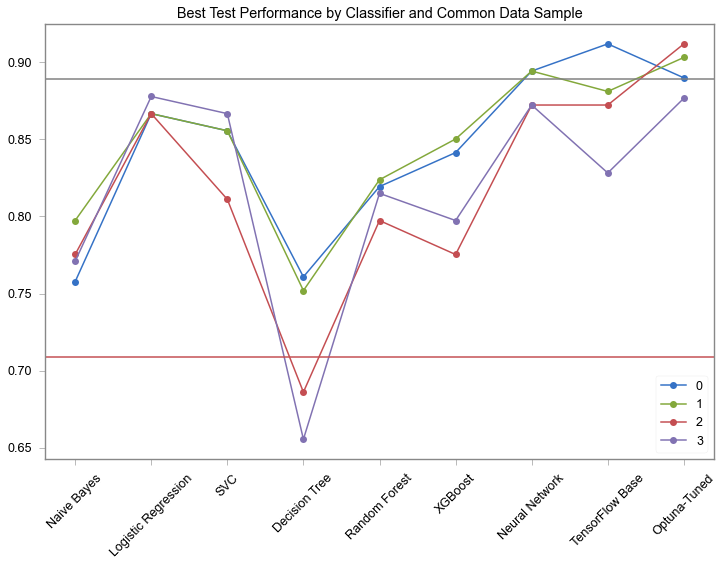

In [110]:
test_results_2 = pd.DataFrame([nb_test_accuracies, lr_test_accuracies, svc_test_accuracies, dt_test_accuracies,
                            rf_test_accuracies, XGB_test_accuracies, nn_test_accuracies, tf_results_test_accuracy,
                            optuna_score])

test_results_2 = test_results_2[[0, 1, 2, 3]]

test_results_2['Classifier'] = ['Naive Bayes', 'Logistic Regression', 'SVC', 'Decision Tree', 'Random Forest', 'XGBoost',
                             'Neural Network', 'TensorFlow Base', 'Optuna-Tuned']

test_results_2.set_index('Classifier', inplace = True)

plt.figure(figsize=(12,8))
plt.plot(test_results_2, marker = 'o')
plt.xticks(rotation = 45, color = 'black')
plt.yticks(color = 'black')
plt.axhline(y=0.709, color='r', linestyle='-')
plt.axhline(y=0.889, color='gray', linestyle='-')
legend = plt.legend((test_results_2.columns), loc = 'lower right')
plt.setp(legend.get_texts(), color='black')
plt.title('Best Test Performance by Classifier and Common Data Sample', color = 'black');

In [111]:
test_results_2

0         1         2         3
Classifier                                                 
Naive Bayes          0.757709  0.797357  0.775330  0.770925
Logistic Regression  0.866667  0.866667  0.866667  0.877778
SVC                  0.855556  0.855556  0.811111  0.866667
Decision Tree        0.760833  0.751944  0.686111  0.655556
Random Forest        0.819383  0.823789  0.797357  0.814978
XGBoost              0.841410  0.850220  0.775330  0.797357
Neural Network       0.894273  0.894273  0.872247  0.872247
TensorFlow Base      0.911894  0.881057  0.872247  0.828194
Optuna-Tuned         0.889868  0.903084  0.911894  0.876652

# Yes, but is it significant?

So, in order to determine whether these differences are statistically significant, I am going to apply McNemar's Test.  I can't use a TTest here because I used a k-fold test to derive these accuracies.  So, even though the Train / Test splits are the same across each classifier, the k-fold means that I can't compare the results with that test.

McNemar's Test captures the errors made by both models. Specifically, the No/Yes and Yes/No cells in the contingency table. The test checks if there is a significant difference between the counts in these two cells. That is all.  This definition comes from https://machinelearningmastery.com/mcnemars-test-for-machine-learning/.

In [192]:
from statsmodels.stats.contingency_tables import mcnemar

classifier_list = test_results_2.index.to_list()
sample_list = test_results_2.columns.to_list()
yes, no = [], []

if len(X0_test) ==  len(X1_test) == len(X2_test) == len(X3_test):
    
    test_length = len(X0_test)
    
    for cl in classifier_list:
        class_yes = []
        class_no = []
        for sl in sample_list:
            y = test_results_2.loc[cl, sl] * test_length
            n = test_length - y
            
            class_yes.append(y)
            class_no.append(n)
        yes.append(class_yes)
        no.append(class_no)
        
# So, what I need to do to answer my questions is:

# Compare the classifier (first value) on different samples (the second value), so NB on 0 and NB on 1
# I want to do this for every classifier to see if it makes a difference.  [n][0] and [n][1], then [n][2] and [n][3]

# contingency_tables_01 = []
# contingency_tables_23 = []

for cl, n in zip(classifier_list, range(len(classifier_list))):
        contingency_table_01 = [[(yes[n][0] + yes[n][1]), (yes[n][0] + no[n][1])],
                                [(no[n][0] + yes[n][1]), (no[n][0] + no[n][1])]]
        
        contingency_table_23 = [[(yes[n][2] + yes[n][3]), (yes[n][2] + no[n][3])],
                                [(no[n][2] + yes[n][3]), (no[n][2] + no[n][3])]]
        
        result01 = mcnemar(contingency_table_01, exact=False, correction=True)
        
        result23 = mcnemar(contingency_table_23, exact=False, correction=True)
        
#         print('For '+cl+' on 0/1 comparison: statistic=%.3f, p-value=%.3f' % (result01.statistic, result01.pvalue))

        # interpret the p-value
        alpha = 0.05
        if result01.pvalue > alpha:
            print('')
        else:
            print('For '+cl+' on 0/1 comparison: statistic=%.3f, p-value=%.3f' % (result01.statistic, result01.pvalue))
            print('Different proportions of errors (reject H0, the difference between H0 and H1 is statistically significant.)\n')
            
#         print('For '+cl+' on 2/3 comparison: statistic=%.3f, p-value=%.3f' % (result23.statistic, result23.pvalue))

        # interpret the p-value
        alpha = 0.05
        if result23.pvalue > alpha:
            print('')
        else:
            print('For '+cl+' on 0/1 comparison: statistic=%.3f, p-value=%.3f' % (result01.statistic, result01.pvalue))
            print('Different proportions of errors (reject H0, the difference between H0 and H1 is statistically significant.)\n')



# Then I want to compare different classifiers (the first number) on the same sample to see if the difference in
# classifier performance is statistically significant.





In [198]:
for cl, n in zip(classifier_list, range(len(classifier_list))):
        contingency_table_02 = [[(yes[n][0] + yes[n][2]), (yes[n][0] + no[n][2])],
                                [(no[n][0] + yes[n][2]), (no[n][0] + no[n][2])]]
        
        contingency_table_13 = [[(yes[n][1] + yes[n][3]), (yes[n][1] + no[n][3])],
                                [(no[n][1] + yes[n][3]), (no[n][1] + no[n][3])]]
        
        result02 = mcnemar(contingency_table_02, exact=False, correction=True)
        
        result13 = mcnemar(contingency_table_13, exact=False, correction=True)
        

        # interpret the p-value
        alpha = 0.05
        if result02.pvalue > alpha:
            print('')
        else:
            print('For '+cl+' on 0/2 comparison: statistic=%.3f, p-value=%.3f' % (result02.statistic, result02.pvalue))
            print('Different proportions of errors (reject H0, the difference between H0 and H1 is statistically significant.)\n')

        # interpret the p-value
        alpha = 0.05
        if result13.pvalue > alpha:
            print('')
        else:
            print('For '+cl+' on 1/3 comparison: statistic=%.3f, p-value=%.3f' % (result13.statistic, result13.pvalue))
            print('Reject H0, the difference between H0 and H1 is statistically significant.)')









For Decision Tree on 1/3 comparison: statistic=4.027, p-value=0.045
Reject H0, the difference between H0 and H1 is statistically significant.)












In [196]:
for b in range(8):
    for e in range(b+1,9):
        for s in sample_list:
        
            contingency_table_two = [[(yes[b][s] + yes[e][s]), (yes[b][s] + no[e][s])],
                                     [(no[b][s] + yes[e][s]), (no[b][s] + no[e][s])]]
            
            result_two = mcnemar(contingency_table_two, exact=False, correction=True)
            
            alpha = 0.05
            if result_two.pvalue > alpha:
#                 print('Same proportions of errors (fail to reject H0, keep the null hypothesis.)')
                print('')
            else:
                print('Comparing '+classifier_list[b]+' and '+classifier_list[e]+' on sample '+str(s)+': statistic=%.3f, p-value=%.3f' % (result_two.statistic, result_two.pvalue))
                print('Reject H0.  Different proportions of errors.')
            
            
            
            

Comparing Naive Bayes and Logistic Regression on sample 0: statistic=5.174, p-value=0.023
Reject H0.  Different proportions of errors.


Comparing Naive Bayes and Logistic Regression on sample 3: statistic=4.972, p-value=0.026
Reject H0.  Different proportions of errors.
Comparing Naive Bayes and SVC on sample 0: statistic=4.153, p-value=0.042
Reject H0.  Different proportions of errors.


Comparing Naive Bayes and SVC on sample 3: statistic=3.972, p-value=0.046
Reject H0.  Different proportions of errors.



Comparing Naive Bayes and Decision Tree on sample 3: statistic=5.814, p-value=0.016
Reject H0.  Different proportions of errors.








Comparing Naive Bayes and Neural Network on sample 0: statistic=8.196, p-value=0.004
Reject H0.  Different proportions of errors.
Comparing Naive Bayes and Neural Network on sample 1: statistic=4.073, p-value=0.044
Reject H0.  Different proportions of errors.
Comparing Naive Bayes and Neural Network on sample 2: statistic=4.073, p-value=0.044
Rej

# Results on the Validation Sample

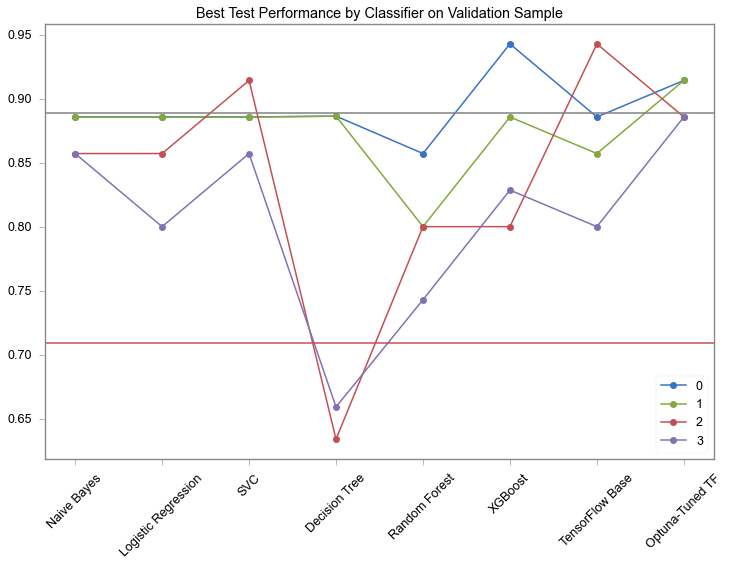

In [112]:
val_results = pd.DataFrame([nb_validation_accuracies, lr_validation_accuracies, svc_validation_accuracies, 
                            dt_val_accuracies, rf_val_accuracies, XGB_val_accuracies, tf_results_validation_accuracy,
                           optuna_val_scores])
                           
#                            , nn_test_accuracies, tf_results_test_accuracy,
#                             optuna_score])

val_results['Classifier'] = ['Naive Bayes', 'Logistic Regression', 'SVC', 'Decision Tree', 'Random Forest', 'XGBoost',
                            'TensorFlow Base', 'Optuna-Tuned TF']
#                              'Neural Network', 'TensorFlow Base', 'Optuna-Tuned TF']

val_results.set_index('Classifier', inplace = True)

plt.figure(figsize=(12,8))
plt.plot(val_results, marker = 'o')
plt.xticks(rotation = 45, color = 'black')
plt.yticks(color = 'black')
plt.axhline(y=0.709, color='r', linestyle='-')
plt.axhline(y=0.889, color='gray', linestyle='-')
legend = plt.legend((val_results.columns), loc = 'lower right')
plt.setp(legend.get_texts(), color='black')
plt.title('Best Test Performance by Classifier on Validation Sample', color = 'black');

In [105]:
val_results

0         1         2         3
Classifier                                                 
Naive Bayes          0.885714  0.885714  0.857143  0.857143
Logistic Regression  0.885714  0.885714  0.857143  0.800000
SVC                  0.885714  0.885714  0.914286  0.857143
Decision Tree        0.886364  0.886364  0.633838  0.659091
Random Forest        0.857143  0.800000  0.800000  0.742857
XGBoost              0.942857  0.885714  0.800000  0.828571
TensorFlow Base      0.885714  0.857143  0.942857  0.800000
Optuna-Tuned TF      0.914286  0.914286  0.885714  0.885714

# Summary / Conclusion

This project was born from curiosity.  I built my own dataset, combining a variety of publicly available sources and the mechanics of building that dataset, merging data, and dealing with anomolaies just to get a workable dataset was an adventure all by itself.  I thought about how to pull this together and worked on it for a very long time.

Once I got the data together, the Exploratory Data Analysis (EDA) was very interesting.  The EDA didn't reveal anything earth shattering, but it did reveal that all of the PI had normal distributions so that normal statistical methods could be applied without creating any problems.

My first research question dealt with the value of the Average Meters Gained (AMG) Performance Indicator (PI).  Young, et.al. found that Meters Gained was the most important PI for explaining Wins and Losses.  AFLtables.com, my primary source of PI information, did not include AMG, so I was skeptical that AMG could have that much predictive power.  So, I set up my first research question where the only difference between the samples was the presence of AMG.

I did not find that AMG added any statistically significant value to the analysis.

My second research question stemmed from a curiousity about diving deeper into the data, breaking the aggregate team PI into PI broken out by Position Group (POSGRU).  I admit that my POSGRU breakout was not necessarily 100% accurate: I did copious research on public websites to identify the player's position, and where there was a hybrid position listed, I selected the first one listed.  I broke the data into four POSGRU: Forwards, Midfielders, Defenders, and Rucks.

I wanted to see if a tuned Neural Network could navigate through this expanded dataset to find hidden patterns that might uncover relationships that other classifiers missed.

The biggest revelation in Neural Networks was Optuna.  Tuning hyperparameters is computationally expensive and tuning hyperparameters in isolation or small groups diminishes the full power of a grid search.  Optuna allows you to search on almost every hyperparameter of which you can conceive, as well as layers and neurons.  It "speeds" through the combinations, abandoning those that perform poorly while rapidly honing in on the combination that performs best.  You can have it minimize loss or maximize accuracy (or any other metric).  I had my Optuna models maximize accuracy.

And, I found that the tuned Neural Networks did a very good job on my dataset, exceeding the benchmark of 88.9% accuracy set by Young, et.al. but, the difference in performance between the other classifiers and the Optuna-tuned Neural Network was not statistically significant, according to McNemar's test.

The models performed reasonably well on a very small sample of validation data from the ongoing 2021 season.  There have been blowouts and one-point games, completely predictable results (Carlton losing to Richmond...again) and jaw-dropping surprises (Demons, Bulldogs, Swans, and the Crows' opening round victory over Geelong), but the model still performs within the boundaries established on the 2015 - 2020 test data.

I still believe that the POSGRU data offers more explanatory power, but the target variable may not be Wins or Losses (an extra hit-out, or a lost midfield possession is not going to change the outcome of the game).  I have been in contact with Champion Data (the official stats provider for AFL) and I hope to get access to a much richer dataset and explore these POSGRU-based contests in more detail and see if I can create a Neural Network that will explore the game in all of its richness and complexity.

# References

**Primary References:**

Fahey-Gilmour, J., Dawson, B., Peeling, P., Heasman, J., & Rogalski B.; "Multifactorial analysis of factors influencing elite Australian football match outcomes: a machine learning approach"; International Journal of Computer Science in Sport, Volume 18, Issue 3, 2019

Young, Christopher M.; Luo, Wei; Gastin, Paul; Tran, Jacqueline; Dwyer, Dan B.; "The Relationship between Match Performance Indicators and Outcome in Australian Football"; 'Journal of Science and Medicine in Sport' (2018); https://doi.org/10.1016/j.jsams.2018.09.235

Raschka, Sebastian. Python Machine Learning: Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow 2, 3rd Edition . Packt Publishing. Kindle Edition.

Muller, Andreas C., Guido, Sarah; (2017). "Introduction to Machine Learning with Python, A Guide for Data Scientists"; O'Reilly

Geron, Aurelien; 2019; "Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow"; O'Reilly